In [1]:
### Make notebook wider:

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))




In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics
import json
from PIL import Image, ImageDraw, ImageFont
import seaborn as sns;
import json
import pickle
import ast
import scipy

%matplotlib inline

def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')
    plt.close()
    
def return_inds_for_seq_groups(lst):
    groups = []
    new = True
    for ind,item in enumerate(lst):
        if new:
            if item > 0:
                start = ind
                new = False
        else:
            if item == 0:
                end = ind-1
                groups.append((start, end))
                new = True
    return groups

def process_awake_data_return_seq_dfs(unmasked_spikes_df,chunk_time,file_path,awake_neuron_order,colors):

    seqs = np.unique(unmasked_spikes_df.sequence_type_adjusted)
    seq_spikes = []
    for seq_type_ in seqs:  
        seq_spikes += [unmasked_spikes_df.timestamp[np.where(unmasked_spikes_df.sequence_type_adjusted ==seq_type_)[0]].values]

    # Define the bin size (in this case, 0.2s)
    bin_size = 0.2

    seq_spike_occurance = []
    for spikes_ in seq_spikes:
        # Use the numpy.histogram function to bin the data
        hist, bins = np.histogram(spikes_, bins=np.arange(0, np.diff(chunk_time)[0], bin_size))
        seq_spike_occurance += [list(hist)]

    seq_size_threshold= 5

    seq_event_dfs = []
    for i in range(1,7):
        print(i)

        seq_spike_count = seq_spike_occurance[i]
        # find seq start and end, defined by whetehr there were spikes or not 
        groups = return_inds_for_seq_groups(seq_spike_count)

        ### plot to check that I am accounting ofr sequences properly

        #mask
        # spikemask
        timeframe = [0,800]
        mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])
        background_remove_mask = unmasked_spikes_df[mask].sequence_type_adjusted >= 0
        c_ = np.array(colors)[unmasked_spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]

        fig,[ax1,ax2] = plt.subplots(2, 1,figsize=(10, 5))
        ax1.scatter(unmasked_spikes_df[mask][background_remove_mask].timestamp, awake_neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)
        ax2.plot(seq_spike_count, color = colors[i])
        for item in groups:
            ax2.plot(item,[-5,-5], color = 'red')

        ax1.set_xlim([0,100])
        ax2.set_xlim([0,(100/bin_size)])

        for group in groups:

            # spikemask
            timeframe = [(group[0] * bin_size)-0.5,(group[-1] * bin_size)+0.5]
            mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])
            seq_mask = unmasked_spikes_df[mask].sequence_type_adjusted == i

            if len(unmasked_spikes_df[mask][seq_mask]) > seq_size_threshold:
                seq_event_dfs += [unmasked_spikes_df[mask][seq_mask]]
                
    #### save out      
    with open(file_path, 'wb') as file:
        pickle.dump(seq_event_dfs, file)
        
    return(seq_event_dfs)

def awake_seqs_find_neuron_time_occurances(awake_seq_event_dfs,seq_type):
    neuron_time_occurances = {}
    # loop across awake seq events
    for index,awake_seq in enumerate(awake_seq_event_dfs):
        if awake_seq.sequence_type.values[0] == seq_type:
            # determine relative spiek times
            relataive_ts = awake_seq.timestamp-min(awake_seq.timestamp)
            max_ts = max(relataive_ts)

            # loop across each neuron in the seq and save this data out 
            for neuron_id in awake_seq.neuron.unique():
                mask = awake_seq.neuron == neuron_id
                #mask by neuron id and determine when it occured - in relative time 
                proportional_event_time_occurance = relataive_ts[mask].values/max_ts
                if neuron_id not in neuron_time_occurances:
                    neuron_time_occurances[neuron_id] = list(proportional_event_time_occurance)
                else:
                    neuron_time_occurances[neuron_id] += list(proportional_event_time_occurance)
    return neuron_time_occurances

def sleep_seqs_find_neuron_time_occurances(replay_motif_data,seq_type):

    neuron_time_occurances ={}
    seq_type_replay_motif_data = replay_motif_data[replay_motif_data.cluster_seq_type == seq_type]
    for index, spike_times in enumerate(seq_type_replay_motif_data.cluster_spike_times):
        spike_times = np.array(ast.literal_eval(spike_times))
        cluser_ids = ast.literal_eval(seq_type_replay_motif_data.cluster_neurons[index])

        # determine relative spiek times
        relataive_ts = spike_times-min(spike_times)
        max_ts = max(relataive_ts)

        # loop across each neuron in the seq and save this data out 
        for neuron_id in np.unique(cluser_ids):
            mask = cluser_ids == neuron_id
            #mask by neuron id and determine when it occured - in relative time 
            proportional_event_time_occurance = relataive_ts[mask]/max_ts
            if neuron_id not in neuron_time_occurances:
                neuron_time_occurances[neuron_id] = list(proportional_event_time_occurance)
            else:
                neuron_time_occurances[neuron_id] += list(proportional_event_time_occurance)
    return neuron_time_occurances

yellow = '#E2DC92'
green = '#69BD9D'
blue = '#1C79B5'
red = '#BE575F'
dark_blue = '#264999'
purple = '#724F94'
gold = '#C6963E'

In [24]:
PP_PATH = r"Z:\projects\sequence_squad\revision_data\organised_data\ppseq_data\output_data\striatum\Post_sleep_AP5\\"
# DAT_PATH = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"
DAT_PATH = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"




In [18]:
os.listdir(dat_path)[2:3]

['149_1_1_run_0409025_1305']

In [ ]:
# dat_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\striatum\New_Post_sleep\\"
# dat_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\"
# analysis_folder = r'\\_final_analysis_output'
# sleep_time_point_df = pd.read_csv(dat_path + 'sleep_time_points.csv')


# dat_path = r"Z:\projects\sequence_squad\revision_data\organised_data\ppseq_data\output_data\striatum\Post_sleep_AP5\\"
dat_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\second_attempt\\"


analysis_folder = r'\\_final_analysis_output'

sleep_time_point_df = pd.read_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\AP5_data\sleep_time_points.csv")

# awake_PP_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\AP5_data\awake\\"
awake_PP_path = r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\expert\awake\\"


sleep_start = {}
for index,value in enumerate(sleep_time_point_df.approx_sleep_start.values):
    mouse = sleep_time_point_df.mir.values[index]
    
    if 'Pre_sleep' in dat_path:
        value = 0
    sleep_start[mouse] = value

# expert_mice = sleep_time_point_df[sleep_time_point_df.group == current_group].mir.values

mirs = []
for run_index,pp_file in enumerate(os.listdir(dat_path)[-1::]):
#     run_index = 2
# for run_index in range(1):)
#     pp_file = '262_1_4_run_2106023_2357'
    
    print(run_index)
#     if not run_index == 16 and run_index>-1:

    if not 'sleep_time_points' in pp_file and not 'quick' in pp_file:
        mouse = '_'.join(pp_file.split('_')[0:3])
        print('----------------------------------------------------')
        print(mouse)
#         if mouse in expert_mice:

        current_mouse_path = dat_path + pp_file + analysis_folder
        mirs += ['_'.join(pp_file.split('_')[0:3])]
        for file in os.listdir(current_mouse_path):
            if 'chunk' in file:
                print(file)
                print(mouse)
                if 'revision_data' in dat_path:
                    current_sleep_start = 0
                else:
                    current_sleep_start = sleep_start[mouse]
                current_data_path = current_mouse_path + '\\' + file + '\\'
                chunk_time = np.load(current_data_path + 'chunk_time_interval.npy')

                if chunk_time[0] > current_sleep_start:
                    replay_motif_data = pd.read_csv(current_data_path + 'filtered_replay_clusters_df.csv')
                    reactivations_found = len(replay_motif_data)
                    mins = np.diff(chunk_time)[0]/60
                else:
                    replay_motif_data = pd.read_csv(current_data_path + 'filtered_replay_clusters_df.csv')
                    post_sleep_mask = replay_motif_data.first_spike_time > (current_sleep_start - chunk_time[0] )
                    replay_motif_data = replay_motif_data[post_sleep_mask]
                    reactivations_found = len(replay_motif_data)
                    mins = np.diff(chunk_time)[0]/60

                out_path = current_data_path + 'temporal_structure_analysis\\'

                #################################################################################################################################
                ## load awake data


                


                for file_ in os.listdir(awake_PP_path):
                    if mouse in file_:
                        awake_file = file_

                #### load in awake task data dn determine awake sequence ordering:

                with open(awake_PP_path + awake_file + r'\analysis_output\\' + 'spikes_seq_type_adjusted.pickle', 'rb') as handle:
                    unmasked_spikes_df = pickle.load(handle)

                with open(awake_PP_path + awake_file + r'\analysis_output\reordered_recolored\\' + 'neuron_order', 'rb') as handle:
                    awake_neuron_order = pickle.load(handle)


                ordered_preferred_type = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'ordered_preferred_type')

                neuron_index = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'neuron_index')

                colors = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'colors')

                spikes_df = unmasked_spikes_df

                colors += ['pink','lightblue', 'k'] 

                #### process/load processed awake data 

                if not os.path.isdir(current_data_path + 'temporal_structure_analysis\\'):
                    os.mkdir(current_data_path + 'temporal_structure_analysis\\')

                file_path = current_data_path + 'temporal_structure_analysis\\' + 'awake_seq_event_dfs.pkl'
                if not os.path.isfile(file_path):
                    print('processing')
                    awake_seq_event_dfs = process_awake_data_return_seq_dfs(unmasked_spikes_df,chunk_time,file_path,awake_neuron_order,colors)
                else:
                    with open(file_path, 'rb') as file:
                        awake_seq_event_dfs = pickle.load(file)
                        print('loading')

                # determine how mnay events occured in awake 
                awake_seq_events = {}
                for awake_seq in awake_seq_event_dfs:
                    type_ = awake_seq.sequence_type.values[0]

                    if type_ not in awake_seq_events:
                        awake_seq_events[type_] = 0
                    else:
                        awake_seq_events[type_] += 1

                ## for each seq event detemine the average position of each neuron (av spike time relative to length of motif). 
                #I only take awake neurons that occur in at least 5% of awake seqs and I exclude neurons that tend fire at the very edges of the motifs (the first and last (top and bottom) 5% of neurons)
                all_awake_mean_motif_lengths= []
                all_awake_neruon_ref_df = []
                per_seq_awake_neuron_time_occurances = []
                fig, ax = plt.subplots(1,6, figsize=(5*6,5))
                for seq_type in range(1,7):
                    print(seq_type)

                    event_length = []
                    for awake_seq in awake_seq_event_dfs:
                        if awake_seq.sequence_type.values[0] == seq_type:
                            event_length += [max(awake_seq.timestamp) - min(awake_seq.timestamp)]
                    awake_mean_motif_length = np.mean(event_length)

                    neuron_time_occurances = awake_seqs_find_neuron_time_occurances(awake_seq_event_dfs,seq_type)

                    dat = []
                    err = []
                    neuron_ids = []
                    for neuron_id in neuron_time_occurances:
                        # if it is in at least 10% of seqs
                        if len(neuron_time_occurances[neuron_id]) > int(awake_seq_events[seq_type]*0.05):
                            neuron_ids += [neuron_id]
                            dat +=[np.mean(neuron_time_occurances[neuron_id])]
                            err += [scipy.stats.sem(neuron_time_occurances[neuron_id])]


                    sorting_index = np.argsort(dat)
                    x = list(range(0,len(dat)))
                    for i in range(len(x)):
                        ax[seq_type-1].errorbar(x[i],np.array(dat)[sorting_index][i], yerr=np.array(err)[sorting_index][i], fmt='o')

                    ax[seq_type-1].axhline(np.percentile(dat, 95) )
                    ax[seq_type-1].axhline(np.percentile(dat, 5) )
                    ax[seq_type-1].set_title('seq' + str(seq_type))

                    # save out all the relative neuron times for awake sequences to make comparison plot with slepe neurons
                    per_seq_awake_neuron_time_occurances += [neuron_time_occurances]

                    # filter out top and bottom 5%
                    filtered_dat = []
                    filtered_neuron_ids = []
                    for index,item in enumerate(dat):
                        if item > np.percentile(dat, 10) and item < np.percentile(dat, 90):
                            filtered_dat += [item]
                            filtered_neuron_ids += [neuron_ids[index]]
                            
                    if len(filtered_dat) > 0:

                        # mak eit relative again
                        rel_filtered_dat = np.array(filtered_dat) - min(filtered_dat)
                        rel_filtered_dat = rel_filtered_dat/ max(rel_filtered_dat)


                    #     # also do this for mean length as this wlll change also 
                        awake_mean_motif_length = (max(filtered_dat) - min(filtered_dat)) * awake_mean_motif_length
                        all_awake_mean_motif_lengths += [awake_mean_motif_length]

                        sorting_index = np.argsort(filtered_dat)
                        awake_neuron_order = np.array(filtered_neuron_ids)[sorting_index]
                        awake_neruon_ref_df = pd.DataFrame({'neuron_id' : awake_neuron_order, 'relative_occurance_time' : np.array(rel_filtered_dat)[sorting_index]})

                        all_awake_neruon_ref_df += [awake_neruon_ref_df]
                    else:
                        all_awake_neruon_ref_df += [[]]


                SaveFig('seq_neuron_time_offset_filtering.png',out_path)


                with open(out_path+'awake_seq_neuron_position_ref_dfs', 'wb') as f:
                    pickle.dump(all_awake_neruon_ref_df, f)


                #################################################################################################################################


                ### describe what is happening for future emmett! 
                # here for each replay event I take the relative event spike times and find the regression line  against the corresponding av awake time (relative awake time) for each neuron.
                ## for each regression check first if it has a reasonbly good correlation (r value > 0.5):
                ## then check if the slope is slopey enough (slope steeper than 4x less steep than av. awake)
                ## this means it has temporal order
                # if not these then check if it has a reasonbly good r2 correlation (the line fits the data well) (r2 value > 0.5) 
                # and a flat slope (slope less steep than 4x less steep  av. awake)
                # this means it is stationsary 
                # other wise put it in misordered/ other (could be a mixture of frward and backward or something)

                # otherwsie put it in misordered/ other
                from scipy.stats import linregress 

                regression_df = pd.DataFrame({})
                stationary_regression_df = pd.DataFrame({})
                fragmented_regression_df = pd.DataFrame({})

                fig, ax = plt.subplots(1,6, figsize=(5*6,5))
                non_significants = []
                significants = []
                sig_stationaries = []
                skipped_ID = []
                for seq_type in range(1,7):
                    print(seq_type)
                    awake_neruon_ref_df = all_awake_neruon_ref_df[seq_type-1]

                    seq_type_replay_motif_data = replay_motif_data[replay_motif_data.cluster_seq_type == seq_type].reset_index()

                    regression_line = []
                    x_vals = []
                    y_vals = []
                    event_lengths = []
                    slopes = []
                    r_values = []
                    reactivation_ID = []
                    non_significant = 0
                    stationary = 0

                    stationar_regression_line = []
                    stationary_x_vals = []
                    stationary_y_vals = []
                    stationary_reactivation_ID = []
                    stationary_slopes = []

                    other_x_vals = []
                    other_y_vals = []
                    other_regression_line = []
                    other_reactivation_ID = []

                    for index_, spike_times in enumerate(seq_type_replay_motif_data.cluster_spike_times):

                            spike_times = np.array(ast.literal_eval(spike_times))
                            cluser_ids = ast.literal_eval(seq_type_replay_motif_data.cluster_neurons[index_])

                            # filter so only spikes that are in awake are considered:
                            filt_cluser_ids = []
                            filt_spike_times = []
                            for index,id_ in enumerate(cluser_ids):
                                if len(awake_neruon_ref_df) > 0:
                                    if id_ in awake_neruon_ref_df.neuron_id.values:
                                        filt_cluser_ids +=[id_]
                                        filt_spike_times += [spike_times[index]]

                            # TEST - WAS 3
                            if len(filt_spike_times) > 5:

                                # make them all relative again (getting rid of some values may ahve changed this)
                                filt_rel_spike_times = filt_spike_times - min(filt_spike_times)
                                event_length = max(filt_rel_spike_times)



                                awake_rel_occurance_times = []
                                for cluser_id in filt_cluser_ids:
                                    awake_rel_occurance_times += [awake_neruon_ref_df[awake_neruon_ref_df.neuron_id == cluser_id].relative_occurance_time.values[0]]

                                try:
                                    x = np.array(filt_rel_spike_times)
                                    y = np.array(awake_rel_occurance_times)
                                    # Perform linear regression
                                    slope, intercept, r_value, p_value, std_err = linregress(x, y)


                                    awake_mean_motif_length = all_awake_mean_motif_lengths[int(seq_type-1)]
                                    ref_slope = 1/awake_mean_motif_length
                                    if abs(r_value) > 0.4 and abs(slope) > (ref_slope/5):  
                                            # temporally ordered events
                                            # Generate the regression line
                                            regression_line += [slope * x + intercept]
                                            # x valea re actual spike times (realtive to replay event onset)
                                            x_vals += [x]
                                            event_lengths += [event_length]
                                            # not sure thse are useful, they essentially correspond to how complete the event was 
                                            slopes += [slope]
                                            r_values += [r_value]
                                            reactivation_ID+=[seq_type_replay_motif_data['index'][index_]]
                                            y_vals += [y]

                                            ax[seq_type-1].scatter(x, y, label='Data Points')
                                            ax[seq_type-1].plot(x, slope * x + intercept, color='red', label='Regression Line')
                                            ax[seq_type-1].set_xlabel('sleep spike times')
                                            ax[seq_type-1].set_ylabel('correspondng mean awake position neuron corresponds to')




                                    elif (r_value**2) > 0.5 and abs(slope) < (ref_slope/5):
                                            stationar_regression_line += [slope * x + intercept]
                                            stationary_x_vals += [x]
                                            stationary_y_vals += [y]
                                            stationary_reactivation_ID += [seq_type_replay_motif_data['index'][index_]]
                                            stationary_slopes += [slope]
                                            stationary += 1



                                    else:
                                            non_significant += 1
                                            other_x_vals += [x]
                                            other_y_vals += [y]
                                            other_regression_line += [slope * x + intercept]
                                            other_reactivation_ID += [seq_type_replay_motif_data['index'][index_]]


                                except:
                                    print('skipped-for some error')
                            else:
                                print('skip')
                                skipped_ID += [seq_type_replay_motif_data['index'][index_]]






                    if seq_type in np.load(current_data_path+'task_order_seqs.npy')+1:
                        task_involved = [1] * len(reactivation_ID)
                    else:
                        task_involved = [0] * len(reactivation_ID)

                    df = pd.DataFrame({'seq_type' : [seq_type]*len(slopes), 'regression_line' :regression_line,'filt_rel_spike_times' :x_vals,'awake_rel_occurance_times':y_vals,'slope' :slopes, 'reactivation_ID': reactivation_ID,'task_involved': task_involved})
                    non_significants += [non_significant]
                    significants += [len(regression_line)]
                    sig_stationaries += [stationary]

                    regression_df = pd.concat([regression_df, df], axis=0)

                    if seq_type in np.load(current_data_path+'task_order_seqs.npy')+1:
                        task_involved = [1] * len(stationary_reactivation_ID)
                    else:
                        task_involved = [0] * len(stationary_reactivation_ID)

                    stat_df = pd.DataFrame({'seq_type' : [seq_type]*len(stationary_slopes), 'regression_line' :stationar_regression_line,'filt_rel_spike_times' :stationary_x_vals,'awake_rel_occurance_times':stationary_y_vals,'slope' :stationary_slopes, 'reactivation_ID': stationary_reactivation_ID,'task_involved': task_involved})
                    stationary_regression_df = pd.concat([stationary_regression_df, stat_df], axis=0)


                    if seq_type in np.load(current_data_path+'task_order_seqs.npy')+1:
                        task_involved = [1] * len(other_reactivation_ID)
                    else:
                        task_involved = [0] * len(other_reactivation_ID)

                    frag_df = pd.DataFrame({'seq_type' : [seq_type]*len(other_x_vals), 'regression_line' :other_regression_line,'filt_rel_spike_times' :other_x_vals,'awake_rel_occurance_times':other_y_vals, 'reactivation_ID': other_reactivation_ID,'task_involved': task_involved})
                    fragmented_regression_df = pd.concat([fragmented_regression_df, frag_df], axis=0)

                regression_df = regression_df.reset_index(drop = True)
                stationary_regression_df = stationary_regression_df.reset_index(drop = True)
                fragmented_regression_df = fragmented_regression_df.reset_index(drop = True)

                SaveFig('replay_temporal_progression_regression_lines.png',out_path)
#                     regression_df.to_csv(out_path + 'regression_df.csv')
#                     stationary_regression_df.to_csv(out_path + 'stationary_regression_df.csv')
                fragmented_regression_df.to_csv(out_path + 'fragmented_regression_df.csv')



                # update motif data with catagorisations

                catagory = []
                IDs = []
                catagory += (['sequential']*len(regression_df.reactivation_ID.values))
                IDs += list(regression_df.reactivation_ID.values)
                catagory += (['stationary']*len(stationary_regression_df.reactivation_ID.values))
                IDs += list(stationary_regression_df.reactivation_ID.values)
                catagory += (['fragmented']*len(fragmented_regression_df.reactivation_ID.values))
                IDs += list(fragmented_regression_df.reactivation_ID.values)

                final_catagory = []
                counter = 0
                for i in range(len(replay_motif_data)):
                    if not i in sorted(IDs):
                        final_catagory += [np.nan]
                    else:
                        final_catagory += [np.array(catagory)[np.argsort(IDs)][counter]]
                        counter += 1

                replay_motif_data['ordering_classification'] = final_catagory



                # save this out: 
                replay_motif_data.to_csv(current_data_path + 'filtered_replay_clusters_df.csv')

                #################################################################################################################################
                total = np.array(significants) + np.array(sig_stationaries)+ np.array(non_significants) 
                t_involve = []
                fig,ax = plt.subplots(1, 1,figsize=(5, 5))
                for i in range(len(np.array(significants)/total)):
                    if i in np.load(current_data_path+'task_order_seqs.npy'):
                        c_ = 'red'
                        t_involve += [1]
                    else:
                        c_ = 'blue'
                        t_involve += [0]

                    ax.plot([0,1,2],[(np.array(significants)/total)[i],(np.array(sig_stationaries)/total)[i],(np.array(non_significants)/total)[i]],'-o', color = c_)

                labels = ['temporally ordered','stationary','other - misordered?']

                ax.set_xticks(range(0,len(labels)))
                ax.set_xticklabels(labels, rotation=90)
                ax.tick_params(axis='both', which='major', labelsize=20)
                ax.set_title('Red = task motifs')

                df = pd.DataFrame({'seq_type' : range(1,7), 'temporally_ordered' :(np.array(significants)/total),'stationary':(np.array(sig_stationaries)/total),'not_ordered' :(np.array(non_significants)/total),'task_involved' :t_involve })

                SaveFig('temporally_ordered_proportions.png',out_path)
                df.to_csv(out_path + 'temporally_ordered_proportions.csv')




                #################################################################################################################################

#                     ######## NEURON INVOLVEMENT ANALYSIS #########################################################################################################################


#                     # filter for sequential motifs:
#                     sequential_replay_motif_data = replay_motif_data[replay_motif_data.ordering_classification == 'sequential']
#                     sequential_replay_motif_data= sequential_replay_motif_data.reset_index()


#                     ### determine which neurons are involved in awake seqs
#                     all_neurons_list = list(np.unique(unmasked_spikes_df.neuron))

#                     motif_involvements_awake = []
#                     motif_involvements_sleep = []
#                     task_motif_involvements_awake = []
#                     task_motif_involvements_sleep = []
#                     nontask_motif_involvements_awake = []
#                     nontask_motif_involvements_sleep = []

#                     for seq_type in range(1,7):
#                         print(seq_type)

#                         # Determine mean neuron involvements for awake
#                         neuron_motif_involvements = [[] for _ in range(len(all_neurons_list))]
#                         for awake_seq in awake_seq_event_dfs:
#                             if awake_seq.sequence_type_adjusted.values[0] == seq_type:
#                                 for id_, neuron_id in enumerate(all_neurons_list):
#                                     if neuron_id in awake_seq.neuron.values:
#                                         neuron_motif_involvements[id_].append(1)
#                                     else:
#                                         neuron_motif_involvements[id_].append(0)
#                         #find mean involvements:
#                         awake_mean_neuron_motif_involvements = []
#                         for item in neuron_motif_involvements:
#                             if len(item)>0:
#                                 awake_mean_neuron_motif_involvements += [sum(item)/len(item)]
#                             else:
#                                 awake_mean_neuron_motif_involvements += [0]




#                         # Determine mean neuron involvements for sleep
#                         neuron_motif_involvements = [[] for _ in range(len(all_neurons_list))]
#                         for index in range(len(sequential_replay_motif_data)):
#                             if sequential_replay_motif_data.cluster_seq_type[index] == seq_type:
#                                 for id_, neuron_id in enumerate(all_neurons_list):
#                                     if neuron_id in ast.literal_eval(sequential_replay_motif_data.cluster_neurons[index]):
#                                         neuron_motif_involvements[id_].append(1)
#                                     else:
#                                         neuron_motif_involvements[id_].append(0)
#                         #find mean involvements:
#                         sleep_mean_neuron_motif_involvements = []
#                         for item in neuron_motif_involvements:
#                             if len(item)>0:
#                                 sleep_mean_neuron_motif_involvements += [sum(item)/len(item)]
#                             else:
#                                 sleep_mean_neuron_motif_involvements += [0]



# #                         break








#                             ## add involved neurons:
#                             for index, item in enumerate(mean_norm_neuron_motif_involvements):
#                                 if item > 0:
#                                     if mean_norm_neuron_replay_involvements[index] > 0:
#                                         motif_involvements_awake += [item]
#                                         motif_involvements_sleep += [mean_norm_neuron_replay_involvements[index]]
#                                         if seq_type in np.load(current_data_path+'task_order_seqs.npy')+1:
#                                             task_motif_involvements_awake += [item]
#                                             task_motif_involvements_sleep += [mean_norm_neuron_replay_involvements[index]]
#                                         else:
#                                             nontask_motif_involvements_awake += [item]
#                                             nontask_motif_involvements_sleep += [mean_norm_neuron_replay_involvements[index]]

#                     #################################################################################################################################

#                     #### do the same neurons contribute to sleep and awake. 
#                     fig, [ax,ax2,ax3]= plt.subplots(1, 3,figsize=(15, 5))
#                     ax.set_title('all motifs')
#                     sns.regplot(y=motif_involvements_sleep, x=motif_involvements_awake, ax = ax)
#                     ax.set_xlabel('single neuron motif involvement awake')
#                     ax.set_ylabel('single neuron motif involvement sleep')
#                     ax.axhline(0,0,ls ='--')

#                     if len(motif_involvements_awake) > 0:
#                         r, p = scipy .stats.pearsonr(motif_involvements_awake,motif_involvements_sleep)

#                     print(p)
#                     ax.text(0,0.32,'r_sq =' + str(r**2) )

#                     ax.set_xlim(0,0.3)
#                     ax.set_ylim(0,0.3)


#                     ax2.set_title('task motifs')
#                     sns.regplot(y=task_motif_involvements_sleep, x=task_motif_involvements_awake, ax = ax2, color = 'green')
#                     ax2.set_xlabel('single neuron motif involvement awake')
#                     ax2.set_ylabel('single neuron motif involvement sleep')
#                     ax2.axhline(0,0,ls ='--')

#                     if len(task_motif_involvements_awake) > 0:
#                         r, p = scipy .stats.pearsonr(task_motif_involvements_awake,task_motif_involvements_sleep)

#                     print(p)
#                     ax2.text(0,0.32,'r_sq =' + str(r**2) )

#                     ax2.set_xlim(0,0.3)
#                     ax2.set_ylim(0,0.3)


#                     if len(nontask_motif_involvements_sleep) > 0:
#                         ax3.set_title('non task motifs')
#                         sns.regplot(y=nontask_motif_involvements_sleep, x=nontask_motif_involvements_awake, ax = ax3, color = 'red')
#                         ax3.set_xlabel('single neuron motif involvement awake')
#                         ax3.set_ylabel('single neuron motif involvement sleep')
#                         ax3.axhline(0,0,ls ='--')

#                         ax3.set_xlim(0,0.3)
#                         ax3.set_ylim(0,0.3)

#                         r, p = scipy .stats.pearsonr(nontask_motif_involvements_awake,nontask_motif_involvements_sleep)

#                         print(p)
#                         ax3.text(0,0.32,'r_sq =' + str(r**2) )






#                     #### save out figure
#                     ## save out data 


#                     SaveFig('neuron_involvement_awake_sleep_motifs.png',out_path)

#                     all_motif_involvements = pd.DataFrame({'motif_involvements_awake' : motif_involvements_awake, 'motif_involvements_sleep' : motif_involvements_sleep})
#                     all_motif_involvements.to_csv(out_path + 'all_motif_involvements.csv')
#                     task_motif_involvements = pd.DataFrame({'task_motif_involvements_awake' : task_motif_involvements_awake, 'task_motif_involvements_sleep' : task_motif_involvements_sleep})
#                     task_motif_involvements.to_csv(out_path + 'task_motif_involvements.csv')
#                     nontask_motif_involvements = pd.DataFrame({'nontask_motif_involvements_awake' : nontask_motif_involvements_awake, 'nontask_motif_involvements_sleep' : nontask_motif_involvements_sleep})
#                     nontask_motif_involvements.to_csv(out_path + 'nontask_motif_involvements.csv')


#                     #################################################################################################################################

#                     ### determine behaviour reward times:

#                     behav_data_path = r'Z:\projects\sequence_squad\organised_data\animals\\'

#                     ## set dat_path:
#                     for file_ in os.listdir(behav_data_path):
#                         if mouse.split('_')[0] in file_:
#                             if mouse.split('_')[1] == file_[-1]:
#                                 b_dat_path = os.path.join(behav_data_path,file_)
#                     for recording in os.listdir(os.path.join(behav_data_path,b_dat_path)):
#                         if recording.split('_')[0][-1] == mouse.split('_')[-1]:
#                             b_dat_path = os.path.join(b_dat_path,recording)

#                     for file in os.listdir(b_dat_path + r'\behav_sync\\'):
#                         if 'task' in file:
#                             behav_sync = pd.read_csv(b_dat_path + r'\behav_sync\\' + file + '\Behav_Ephys_Camera_Sync.csv')


#                     reward_times_bpod = behav_sync.Reward_Times.values
#                     mask = np.isnan(reward_times_bpod)
#                     # Use the mask to filter out NaN values
#                     reward_times = behav_sync.PokeIN_EphysTime.values[~mask]

#                     # account for time window:
#                     params_file = awake_PP_path + awake_file + r'\trainingData\\' + 'params_' + mouse + '.json'
#                     with open(params_file, 'r') as file:
#                         params = json.load(file)
#                     time_span = params['time_span'][0]
#                     time_span_mask = (reward_times > time_span[0])*(reward_times < time_span[-1])
#                     reward_times = reward_times[time_span_mask]
#                     # convert to relative time
#                     reward_times = reward_times - params['time_span'][0][0]

#                     #################################################################################################################################

#                     ## same as code above but this time I filter for only awake seqs that are related to reward

#                     ### determine which neurons are involved in awake seqs
#                     all_neurons_list = list(np.unique(unmasked_spikes_df.neuron))

#                     motif_involvements_awake = []
#                     motif_involvements_sleep = []
#                     task_motif_involvements_awake = []
#                     task_motif_involvements_sleep = []
#                     nontask_motif_involvements_awake = []
#                     nontask_motif_involvements_sleep = []

#                     for seq_type in range(1,7):
#                         print(seq_type)

#                         ## determine mean neuron involvements for awake 
#                         norm_neuron_motif_involvements = []
#                         for awake_seq in awake_seq_event_dfs: 
#                             if awake_seq.sequence_type.values[0] == seq_type:
#                                 r_elated = False
#                                 for r_time in reward_times:
#                                     for time in awake_seq.timestamp.values:
#                                         if np.diff([time,r_time]) < 2:
#                                             r_elated = True
#                                 if r_elated == True:        
#                                     cluser_involvements = []
#                                     for neuron_id in all_neurons_list:
#                                         cluser_involvements += [list(awake_seq.neuron.values).count(neuron_id)]
#                                     norm_neuron_motif_involvements += [list(np.array(cluser_involvements)/sum(cluser_involvements))]
#                         #find mean involvements:
#                         mean_norm_neuron_motif_involvements = []
#                         for item in conactinate_nth_items(norm_neuron_motif_involvements):
#                             mean_norm_neuron_motif_involvements +=[np.mean(item)]

#                         #find replay neuron involvements per seq type for sleep: 
#                         norm_neuron_replay_involvements = []
#                         if len(sequential_replay_motif_data[sequential_replay_motif_data.cluster_seq_type == seq_type]) > 0:
#                             for neuron_nums in sequential_replay_motif_data[sequential_replay_motif_data.cluster_seq_type == seq_type].cluster_neurons:
#                                 cluser_involvements = []
#                                 for neuron_id in all_neurons_list:
#                                     cluser_involvements += [ast.literal_eval(neuron_nums).count(neuron_id)]
#                                 norm_neuron_replay_involvements += [list(np.array(cluser_involvements)/sum(cluser_involvements))]
#                             #find mean involvements:
#                             mean_norm_neuron_replay_involvements = []
#                             for item in conactinate_nth_items(norm_neuron_replay_involvements):
#                                 mean_norm_neuron_replay_involvements +=[np.mean(item)]

#                             ## add involved neurons:
#                             for index, item in enumerate(mean_norm_neuron_motif_involvements):
#                                 if item > 0:
#                                     if mean_norm_neuron_replay_involvements[index] > 0:
#                                         motif_involvements_awake += [item]
#                                         motif_involvements_sleep += [mean_norm_neuron_replay_involvements[index]]
#                                         if seq_type in np.load(current_data_path+'task_order_seqs.npy')+1:
#                                             task_motif_involvements_awake += [item]
#                                             task_motif_involvements_sleep += [mean_norm_neuron_replay_involvements[index]]
#                                         else:
#                                             nontask_motif_involvements_awake += [item]
#                                             nontask_motif_involvements_sleep += [mean_norm_neuron_replay_involvements[index]]


#                     #################################################################################################################################

#                     #### do the same neurons contribute to sleep and awake. 
#                     ax.set_title('all motifs (reward related awake)')
#                     fig, [ax,ax2,ax3]= plt.subplots(1, 3,figsize=(15, 5))
#                     sns.regplot(y=motif_involvements_sleep, x=motif_involvements_awake, ax = ax)
#                     ax.set_xlabel('single neuron motif involvement reward related awake')
#                     ax.set_ylabel('single neuron motif involvement sleep')
#                     ax.axhline(0,0,ls ='--')

#                     if len(task_motif_involvements_awake) > 0:
#                         r, p = scipy .stats.pearsonr(motif_involvements_awake,motif_involvements_sleep)

#                     print(p)
#                     ax.text(0,0.32,'r_sq =' + str(r) )

#                     ax.set_xlim(0,0.3)
#                     ax.set_ylim(0,0.3)


#                     ax2.set_title('task motifs (reward related awake)')
#                     sns.regplot(y=task_motif_involvements_sleep, x=task_motif_involvements_awake, ax = ax2, color = 'green')
#                     ax2.set_xlabel('single neuron motif involvement reward related awake')
#                     ax2.set_ylabel('single neuron motif involvement sleep')
#                     ax2.axhline(0,0,ls ='--')

#                     if len(task_motif_involvements_awake) > 0:
#                         r, p = scipy .stats.pearsonr(task_motif_involvements_awake,task_motif_involvements_sleep)

#                     print(p)
#                     ax2.text(0,0.32,'r_sq =' + str(r) )

#                     ax2.set_xlim(0,0.3)
#                     ax2.set_ylim(0,0.3)


#                     ax3.set_title('non task motifs (reward related awake)')
#                     sns.regplot(y=nontask_motif_involvements_sleep, x=nontask_motif_involvements_awake, ax = ax3, color = 'red')
#                     ax3.set_xlabel('single neuron motif involvement reward related awake')
#                     ax3.set_ylabel('single neuron motif involvement sleep')
#                     ax3.axhline(0,0,ls ='--')

#                     ax3.set_xlim(0,0.3)
#                     ax3.set_ylim(0,0.3)

#                     if len(nontask_motif_involvements_awake) > 1 and len(nontask_motif_involvements_sleep) > 1:
#                         r, p = scipy .stats.pearsonr(nontask_motif_involvements_awake,nontask_motif_involvements_sleep)

#                         print(p)
#                         ax3.text(0,0.32,'r_sq =' + str(r) )



#                     SaveFig('REWARD_RELATED_neuron_involvement_awake_sleep_motifs.png',out_path)

#                     reward_related_all_motif_involvements = pd.DataFrame({'reward_related_motif_involvements_awake' : motif_involvements_awake, 'reward_related_motif_involvements_sleep' : motif_involvements_sleep})
#                     reward_related_all_motif_involvements.to_csv(out_path + 'reward_related_motif_involvements_awake.csv')
#                     reward_related_task_motif_involvements = pd.DataFrame({'reward_related_task_motif_involvements_awake' : task_motif_involvements_awake, 'reward_related_task_motif_involvements_sleep' : task_motif_involvements_sleep})
#                     reward_related_task_motif_involvements.to_csv(out_path + 'reward_related_task_motif_involvements.csv')
#                     reward_related_nontask_motif_involvements = pd.DataFrame({'reward_related_nontask_motif_involvements_awake' : nontask_motif_involvements_awake, 'reward_related_nontask_motif_involvements_sleep' : nontask_motif_involvements_sleep})
#                     reward_related_nontask_motif_involvements.to_csv(out_path + 'reward_related_nontask_motif_involvements.csv')

                #################################################################################################################################

                if len(regression_df) > 0: 

                    regression_line = regression_df.regression_line.values
                    ### plot the task progression distance - how muhc is usually replayed?
                    distance = []

                    for index in range(len(regression_line)):
                        if np.max(regression_line[index]) > 1:
                            max_ = 1
                        else:
                            max_ = np.max(regression_line[index])
                        if np.min(regression_line[index]) < 0:
                            min_ = 0
                        else:
                            min_ = np.min(regression_line[index])
                        distance += [max_ - min_]

                    fig,ax, = plt.subplots(1, 1,figsize=(5, 5))

                    ax.plot(np.ones(len(distance))*0.3,np.array(distance)*100,'o')
                    ax.plot(np.mean(distance)*100,'<', markersize = 10)

                    groups =  ['data'] * len(distance)
                    dat =  np.array(distance)*100

                    plt_df = pd.DataFrame({'group':groups,'distances (%)': dat })
                    ax=sns.boxplot( y = 'distances (%)', x = 'group', data = plt_df, color = 'blue', width = .2, zorder = 10,\
                                showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
                                showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
                                   saturation = 1, orient = 'v',ax = ax)
                    ax.set_ylabel('progression lenght (percentage of total)')

                    SaveFig('progression_lenght.png',out_path)



                    #################################################################################################################################

                    slopes = regression_df.slope.values
                    x_vals = regression_df.filt_rel_spike_times.values

                    pos_starts = []
                    pos_ends = []
                    for index in range(len(regression_line)):
                        if slopes[index] > 0:
                            s = regression_line[index][np.argsort(x_vals[index])][0]
                            e = regression_line[index][np.argsort(x_vals[index])][-1]

                            if s > 1:
                                 s = 1
                            if s < 0:
                                 s = 0
                            if e > 1:
                                 e = 1
                            if e < 0:
                                 e = 0

                            pos_starts += [s]
                            pos_ends += [e]


                    neg_starts = []
                    neg_ends = []
                    for index in range(len(regression_line)):
                        if slopes[index] < 0:
                            s = regression_line[index][np.argsort(x_vals[index])][0]
                            e = regression_line[index][np.argsort(x_vals[index])][-1]

                            if s > 1:
                                 s = 1
                            if s < 0:
                                 s = 0
                            if e > 1:
                                 e = 1
                            if e < 0:
                                 e = 0

                            neg_starts += [s]
                            neg_ends += [e]

                    ### plot start and end points for frowards and backwards 


                    fig,[ax,ax2] = plt.subplots(1, 2,figsize=(10, 5))

                    ## plot forward start and ends

                    ax.plot(np.array(pos_starts)*100,np.ones(len(pos_starts))*0.3,'o')
                    ax.plot(np.mean(pos_starts)*100,0.3,'^', markersize = 10)

                    ax.plot(np.array(pos_ends)*100,np.ones(len(pos_ends))*0.7,'o')
                    ax.plot(np.mean(pos_ends)*100,0.7,'^', markersize = 10)

                    groups =  ['starts'] * len(pos_starts) + (['ends'] * len(pos_ends))
                    data =  list(np.array(pos_starts)*100) + list(np.array(pos_ends)*100)

                    if len(data) > 0:
                        forward_plt_df = pd.DataFrame({'group':groups,'distances (%)': data })
                        ax=sns.boxplot( x = 'distances (%)', y = 'group', data = forward_plt_df, color = 'blue', width = .2, zorder = 10,\
                                    showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
                                    showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
                                       saturation = 1, orient = 'h',ax = ax)
                        ax.set_xlabel('realtive start point')
                        ax.set_title('forward')


                    ## plot reverse start and ends

                    ax2.plot(np.array(neg_starts)*100,np.ones(len(neg_starts))*0.3,'o')
                    ax2.plot(np.mean(neg_starts)*100,0.3,'^', markersize = 10)

                    ax2.plot(np.array(neg_ends)*100,np.ones(len(neg_ends))*0.7,'o')
                    ax2.plot(np.mean(neg_ends)*100,0.7,'^', markersize = 10)

                    groups =  ['starts'] * len(neg_starts) + (['ends'] * len(neg_ends))
                    data =  list(np.array(neg_starts)*100) + list(np.array(neg_ends)*100)

                    if len(data) > 0:
                        reverse_plt_df = pd.DataFrame({'group':groups,'distances (%)': data })
                        ax=sns.boxplot( x = 'distances (%)', y = 'group', data = reverse_plt_df, color = 'blue', width = .2, zorder = 10,\
                                    showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
                                    showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
                                       saturation = 1, orient = 'h',ax = ax2)
                        ax2.set_xlabel('realtive start point')
                        ax2.set_title('reverse')

                    SaveFig('start_end_points.png',out_path)
                    reverse_plt_df['label'] = ['reverse']*len(reverse_plt_df['group'] )
                    forward_plt_df['label'] = ['forward']*len(forward_plt_df['group'] )
                    out_df = pd.concat([forward_plt_df,reverse_plt_df],axis=0)

                    out_df.to_csv(out_path + 'start_end_df.csv')


                    #################################################################################################################################
                    warp_factor= []
                    fig, ax = plt.subplots(6,2, figsize=(10,5*6))
                    for seq_type,group in regression_df.groupby('seq_type'):

                        p1 = int(seq_type)-1


                        awake_mean_motif_length = all_awake_mean_motif_lengths[int(seq_type-1)]
                        regression_line = group.regression_line.values
                        x_vals = group.filt_rel_spike_times.values
                        slopes = group.slope.values

                        for index,item in enumerate(x_vals):
                            if slopes[index] > 0:
                                ax[p1,0].plot(x_vals[index],regression_line[index],'-')
                            if slopes[index] < 0:
                                ax[p1,1].plot(x_vals[index],regression_line[index],'-')

                        ax[p1,0].set_ylabel('sleep motif progression (relative to awake motif av.)')
                        ax[p1,0].set_xlabel('progression time (s)')

                        ax[p1,0].plot([0,awake_mean_motif_length],[0,1],'o--',c = 'b',label='forward 1x, 5x, 20x',)
                        ax[p1,0].plot([0,awake_mean_motif_length*0.2],[0,1],'o--',c = 'b')
                        ax[p1,0].plot([0,awake_mean_motif_length*0.05],[0,1],'o--',c = 'b')

                        ax[p1,1].plot([0,awake_mean_motif_length],[1,0],'o--',c = 'b',label='reverse 1x, 5x, 20x')
                        ax[p1,1].plot([0,awake_mean_motif_length*0.2],[1,0],'o--',c = 'b')
                        ax[p1,1].plot([0,awake_mean_motif_length*0.05],[1,0],'o--',c = 'b')

                        ax[p1,0].legend()
                        ax[p1,1].legend()


                        ax[p1,0].set_ylim(0,1)
                        ax[p1,1].set_ylim(0,1)

                        ref_slope = 1/awake_mean_motif_length


                        for slope in slopes:
                            warp_factor += [slope/ref_slope]

                    SaveFig('forward_reverse_regression_speed.png',out_path)

                    regression_df['warp_factor'] = warp_factor

                    regression_df.to_csv(out_path + 'regression_df.csv')
                else:        
                    warp_factor = []
                    regression_df['warp_factor'] = warp_factor
                    regression_df.to_csv(out_path + 'regression_df.csv')



                #############################################################################################################################################
                fig,ax = plt.subplots(1, 1,figsize=(10, 5))

                import numpy as np
                import matplotlib.pyplot as plt
                from collections import Counter

                # Define the bin edges
                ### 40x 30x 20x 10x 5x 2x 1x 2x 5x 10x 20x 30x 40x
                # bin_edges = [0.025, 0.033, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 30 ,40]
                bin_edges = [0, 0.05, 0.2, 1, 5, 20, 999999]
                bin_labels = ['.025x & slower','.05:0.2x','.2-1x','1-5x','5-20x','20x & faster']

                # Sample data
                data = np.array(warp_factor)[np.array(warp_factor) > 0]

                # Bin the data and handle values outside the bins
                bin_indices = np.digitize(data, bin_edges)

                # Count the occurrences of each bin index
                bin_counts = Counter(bin_indices)

                # Get the number of bins (including the "other" bin)
                num_bins = len(bin_edges)

                # Create a list to store the counts for each bin
                bin_occurrences = [bin_counts[i] for i in range(1, num_bins)]

                # Set the vertical labels
                ax.set_xticks(range(len(bin_labels)))
                ax.set_xticklabels(bin_labels, rotation=90)

                # Plot the histogram
                ax.bar(bin_labels, bin_occurrences)
                ax.set_xlabel('Bins')
                ax.set_ylabel('Occurrences')
                ax.set_title('warp factors')


                ##### plot reverse warps
                # Sample data
                data = np.array(warp_factor)[np.array(warp_factor) < 0]
                bin_edges = [0, -0.05, -0.2, -1,-5, -20, -999999]
                # Bin the data and handle values outside the bins
                bin_indices = np.digitize(data, bin_edges)

                # Count the occurrences of each bin index
                bin_counts = Counter(bin_indices)

                # Get the number of bins (including the "other" bin)
                num_bins = len(bin_edges)

                # Create a list to store the counts for each bin
                bin_occurrences = [bin_counts[i] for i in range(1, num_bins)]
                # Plot the histogram
                ax.bar(bin_labels, bin_occurrences, alpha = 0.5)


                SaveFig('forward_reverse_warp_factors.png',out_path)


                #################################################################################################################################
                if len(stationary_regression_df) > 0: 
                    stationary_warp_factor= []
                    fig, ax = plt.subplots(6,2, figsize=(10,5*6))
                    for seq_type,group in stationary_regression_df.groupby('seq_type'):

                        p1 = int(seq_type)-1


                        awake_mean_motif_length = all_awake_mean_motif_lengths[int(seq_type-1)]
                        regression_line = group.regression_line.values
                        x_vals = group.filt_rel_spike_times.values
                        slopes = group.slope.values

                        for index,item in enumerate(x_vals):
                            if slopes[index] > 0:
                                ax[p1,0].plot(x_vals[index],regression_line[index],'-')
                            if slopes[index] < 0:
                                ax[p1,1].plot(x_vals[index],regression_line[index],'-')

                        ax[p1,0].set_ylabel('sleep motif progression (relative to awake motif av.)')
                        ax[p1,0].set_xlabel('progression time (s)')

                        ax[p1,0].plot([0,awake_mean_motif_length],[0,1],'o--',c = 'b',label='forward 1x, 5x, 20x',)
                        ax[p1,0].plot([0,awake_mean_motif_length*0.2],[0,1],'o--',c = 'b')
                        ax[p1,0].plot([0,awake_mean_motif_length*0.05],[0,1],'o--',c = 'b')

                        ax[p1,1].plot([0,awake_mean_motif_length],[1,0],'o--',c = 'b',label='reverse 1x, 5x, 20x')
                        ax[p1,1].plot([0,awake_mean_motif_length*0.2],[1,0],'o--',c = 'b')
                        ax[p1,1].plot([0,awake_mean_motif_length*0.05],[1,0],'o--',c = 'b')

                        ax[p1,0].legend()
                        ax[p1,1].legend()


                        ax[p1,0].set_ylim(0,1)
                        ax[p1,1].set_ylim(0,1)

                        ref_slope = 1/awake_mean_motif_length


                        for slope in slopes:
                            stationary_warp_factor += [slope/ref_slope]

                    SaveFig('forward_reverse__stationary_regression_speed.png',out_path)

                    stationary_regression_df['warp_factor'] = stationary_warp_factor

                    stationary_regression_df.to_csv(out_path + 'stationary_regression_df.csv')
                else:
                    stationary_warp_factor = []
                    stationary_regression_df['warp_factor'] = stationary_warp_factor
                    stationary_regression_df.to_csv(out_path + 'stationary_regression_df.csv')

                #############################################################################################################################################
                catagory =[]
                for warp_fact in regression_df.warp_factor:
                    if warp_fact > 0:
                        catagory+=['forward']
                    else:
                        catagory+=['reverse']

                catagory = catagory + (['stationary']*len(stationary_regression_df))
                warps = list(regression_df.warp_factor.values) + list(stationary_regression_df.warp_factor.values) 
                IDs = list(regression_df.reactivation_ID.values) + list(stationary_regression_df.reactivation_ID.values) 
                sort_index = np.argsort(IDs)

                catagory = list(np.array(catagory)[sort_index])
                warps = list(np.array(warps)[sort_index])
                IDs = list(np.array(IDs)[sort_index])

                final_catagory = []
                final_warps = []
                counter = 0
                for i in range(len(replay_motif_data)):
                    if not i in IDs:
                        final_catagory += [np.nan]
                        final_warps += [np.nan]
                    else:
                        final_catagory += [catagory[counter]]
                        final_warps += [warps[counter]]
                        counter += 1

                task_involved = []
                for seq_t in replay_motif_data.cluster_seq_type.values:
                    if seq_t in (np.load(current_data_path+'task_order_seqs.npy')+1):
                        task_involved += [1]
                    else:
                        task_involved += [0]

                replay_motif_data['catagory'] = final_catagory 
                replay_motif_data['warp_factor'] = final_warps 
                replay_motif_data['task_involved'] = task_involved 

                replay_motif_data.to_csv(out_path + 'replay_motif_data_updated.csv')


                ################
                # for each neuron what is its average rleative position in the replay (first to last spike)
                # for each neuron, what is it relative position in replay compared to relative awake

                ##only take sequentail forward replay! 


                def normalize_times(times):
                    min_time = min(times)
                    max_time = max(times)
                    time_range = max_time - min_time

                    normalized_times = [(t - min_time) / time_range for t in times]
                    return normalized_times

                def replace_repeats_with_string(numbers):
                    seen = set()
                    result = []

                    for num in numbers:
                        if num in seen:
                            result.append('repeat')
                        else:
                            result.append(num)
                            seen.add(num)

                    return result




                def determine_neuron_spike_pos(replay_motif_data,seq_type):
                    neuron_spike_positions = {}
                    for i in range(len(replay_motif_data)):

                        if replay_motif_data.cluster_seq_type[i] == seq_type:

                            replay_neurons = ast.literal_eval(replay_motif_data.cluster_neurons[i])
                            replay_spikes = np.array(ast.literal_eval(replay_motif_data.cluster_spike_times[i]))

                            norm_replay_spikes = normalize_times(replay_spikes)

                            replay_neurons_fspike_only = replace_repeats_with_string(replay_neurons)

                            for index,neur_id in enumerate(replay_neurons_fspike_only):
                                if not neur_id == 'repeat':
                                    if neur_id in neuron_spike_positions:
                                        neuron_spike_positions[neur_id] += [norm_replay_spikes[index]]

                                    else:
                                        neuron_spike_positions[neur_id] = [norm_replay_spikes[index]]
                    return neuron_spike_positions


                # only take sequential replay
                sequential_replay_motif_data = replay_motif_data[replay_motif_data.catagory == 'forward']
                sequential_replay_motif_data = sequential_replay_motif_data.reset_index(drop = True)

                forward_neuron_spike_positions_all_seqs = []
                for i in range(1,7):
                    forward_neuron_spike_positions_all_seqs += [determine_neuron_spike_pos(sequential_replay_motif_data,i)]


                # only take sequential replay
                sequential_replay_motif_data = replay_motif_data[replay_motif_data.catagory == 'reverse']
                sequential_replay_motif_data = sequential_replay_motif_data.reset_index(drop = True)

                reverse_neuron_spike_positions_all_seqs = []
                for i in range(1,7):
                    reverse_neuron_spike_positions_all_seqs += [determine_neuron_spike_pos(sequential_replay_motif_data,i)]


                if not 'revision_data' in dat_path:
                    fig, axs = plt.subplots(1,6, figsize=(30,5))

                    for i, ax in enumerate(axs):
                        neuron_spike_positions = forward_neuron_spike_positions_all_seqs[i]
                        if len(neuron_spike_positions) > 1:
                            means = []
                            std_devs = []
                            neurs = []

                            for neuron in neuron_spike_positions:
                                neurs+=[neuron]
                                means+=[np.mean(neuron_spike_positions[neuron])]
                                std_devs+=[scipy.stats.sem(neuron_spike_positions[neuron])]

                            #Sort means and std_devs together based on means
                            sorted_data = sorted(zip(means, std_devs))
                            sorted_means, sorted_std_devs = zip(*sorted_data)

                            #Plot means with error bars
                            ax.errorbar(range(len(means)), sorted_means, fmt='o', capsize=5, color = colors[i+1])

                            #Add labels and title
                            ax.set_ylabel('Mean relative position in replay')

                            ax.set_title(mouse)

    #                         SaveFig(mouse+ '_neuron_mean_relative_pos.pdf',r'Z:\projects\Emmett\Documents\replay_analysis_filtering_options\sequentiality_forward_examples\\')
                    SaveFig(mouse+ '_neuron_mean_relative_pos.png',r'Z:\projects\Emmett\Documents\replay_analysis_filtering_options\sequentiality_forward_examples\\')


                    fig, axs = plt.subplots(1,6, figsize=(30,5))

                    for i, ax in enumerate(axs):
                        neuron_spike_positions = reverse_neuron_spike_positions_all_seqs[i]
                        if len(neuron_spike_positions) > 1:
                            means = []
                            std_devs = []
                            neurs = []

                            for neuron in neuron_spike_positions:
                                neurs+=[neuron]
                                means+=[np.mean(neuron_spike_positions[neuron])]
                                std_devs+=[scipy.stats.sem(neuron_spike_positions[neuron])]

                            #Sort means and std_devs together based on means
                            sorted_data = sorted(zip(means, std_devs))
                            sorted_means, sorted_std_devs = zip(*sorted_data)

                            #Plot means with error bars
                            ax.errorbar(range(len(means)), sorted_means, fmt='o', capsize=5, color = colors[i+1])

                            #Add labels and title
                            ax.set_ylabel('Mean relative position in replay')

                            ax.set_title(mouse)

    #                         SaveFig(mouse+ '_neuron_mean_relative_pos.pdf',r'Z:\projects\Emmett\Documents\replay_analysis_filtering_options\sequentiality_reverse_examples\\')
                    SaveFig(mouse+ '_neuron_mean_relative_pos.png',r'Z:\projects\Emmett\Documents\replay_analysis_filtering_options\sequentiality_reverse_examples\\')


                    ############# neuron relative position in awake and sleep 

                    sleep_neuron_rel_pos = []
                    awake_neurons_rel_pos = []


                    for seq_type in range(6):
                        neuron_spike_positions = forward_neuron_spike_positions_all_seqs[seq_type]
                        if len(neuron_spike_positions) > 1:

                            means = []
                            std_devs = []
                            neurs = []
                            for neuron in neuron_spike_positions:
                                neurs+=[neuron]
                                means+=[np.mean(neuron_spike_positions[neuron])]
                                std_devs+=[scipy.stats.sem(neuron_spike_positions[neuron])]


                            for i,n in enumerate(neurs):
                                if n in all_awake_neruon_ref_df[seq_type].neuron_id.values:
                                    awake_neruon_ref_df.neuron_id == n
                                    awake_neurons_rel_pos += [all_awake_neruon_ref_df[seq_type][all_awake_neruon_ref_df[seq_type].neuron_id == n].relative_occurance_time.values[0]]
                                    sleep_neuron_rel_pos += [means[i]]


                    fig, axs = plt.subplots(1,1, figsize=(5,5))      
                    axs.plot(sleep_neuron_rel_pos,awake_neurons_rel_pos,'o')
                    x = np.linspace(0, 1, 10)  # Example x values
                    y = x  # Since x equals y, y values are the same as x values
                    axs.plot(x,y,'--')

    #                     SaveFig(mouse+ '_neuron_mean_relative_pos.pdf',r'Z:\projects\Emmett\Documents\replay_analysis_filtering_options\sequentiality_reverse_examples\\')
                    SaveFig(mouse+ '_neuron_mean_relative_pos.png',r'Z:\projects\Emmett\Documents\replay_analysis_filtering_options\sequentiality_forwards_examples\\')

                    np.save(out_path + 'neuron_rel_forward_replay_positions.npy',np.array(sleep_neuron_rel_pos))
                    np.save(out_path + 'neuron_rel_awake_positions_forwards.npy',np.array(awake_neurons_rel_pos))  

                    ############################################

                    sleep_neuron_rel_pos = []
                    awake_neurons_rel_pos = []


                    for seq_type in range(6):
                        neuron_spike_positions = reverse_neuron_spike_positions_all_seqs[seq_type]
                        if len(neuron_spike_positions) > 1:
                            awake_neruon_ref_df

                            means = []
                            std_devs = []
                            neurs = []
                            for neuron in neuron_spike_positions:
                                neurs+=[neuron]
                                means+=[np.mean(neuron_spike_positions[neuron])]
                                std_devs+=[scipy.stats.sem(neuron_spike_positions[neuron])]


                            for i,n in enumerate(neurs):
                                if n in all_awake_neruon_ref_df[seq_type].neuron_id.values:
                                    awake_neruon_ref_df.neuron_id == n
                                    awake_neurons_rel_pos += [all_awake_neruon_ref_df[seq_type][all_awake_neruon_ref_df[seq_type].neuron_id == n].relative_occurance_time.values[0]]
                                    sleep_neuron_rel_pos += [means[i]]



                    fig, axs = plt.subplots(1,1, figsize=(5,5))      
                    axs.plot(sleep_neuron_rel_pos,awake_neurons_rel_pos,'o')
                    x = np.linspace(0, 1, 10)  # Example x values
                    y = 1-x  # Since x equals y, y values are the same as x values
                    axs.plot(y,x,'--')

    #                     SaveFig(mouse+ '_neuron_mean_relative_pos.pdf',r'Z:\projects\Emmett\Documents\replay_analysis_filtering_options\sequentiality_reverse_examples\\')
                    SaveFig(mouse+ '_neuron_mean_relative_pos.png',r'Z:\projects\Emmett\Documents\replay_analysis_filtering_options\sequentiality_reversed_examples\\')

                    np.save(out_path + 'neuron_rel_reverse_replay_positions.npy',np.array(sleep_neuron_rel_pos))
                    np.save(out_path + 'neuron_rel_awake_positions_reverse.npy',np.array(awake_neurons_rel_pos))      

         

                    


                    

0
----------------------------------------------------
seq006_1_11
chunk1_950to2950
seq006_1_11
processing
1
2
3
4
5
6
1
2
3
4
5
6
1
2
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip


In [36]:
dat

[]

In [ ]:
awake_neruon_ref_df

In [ ]:
                for seq_type in range(1,7):
                    print(seq_type)
                    awake_neruon_ref_df = all_awake_neruon_ref_df[seq_type-1]

2


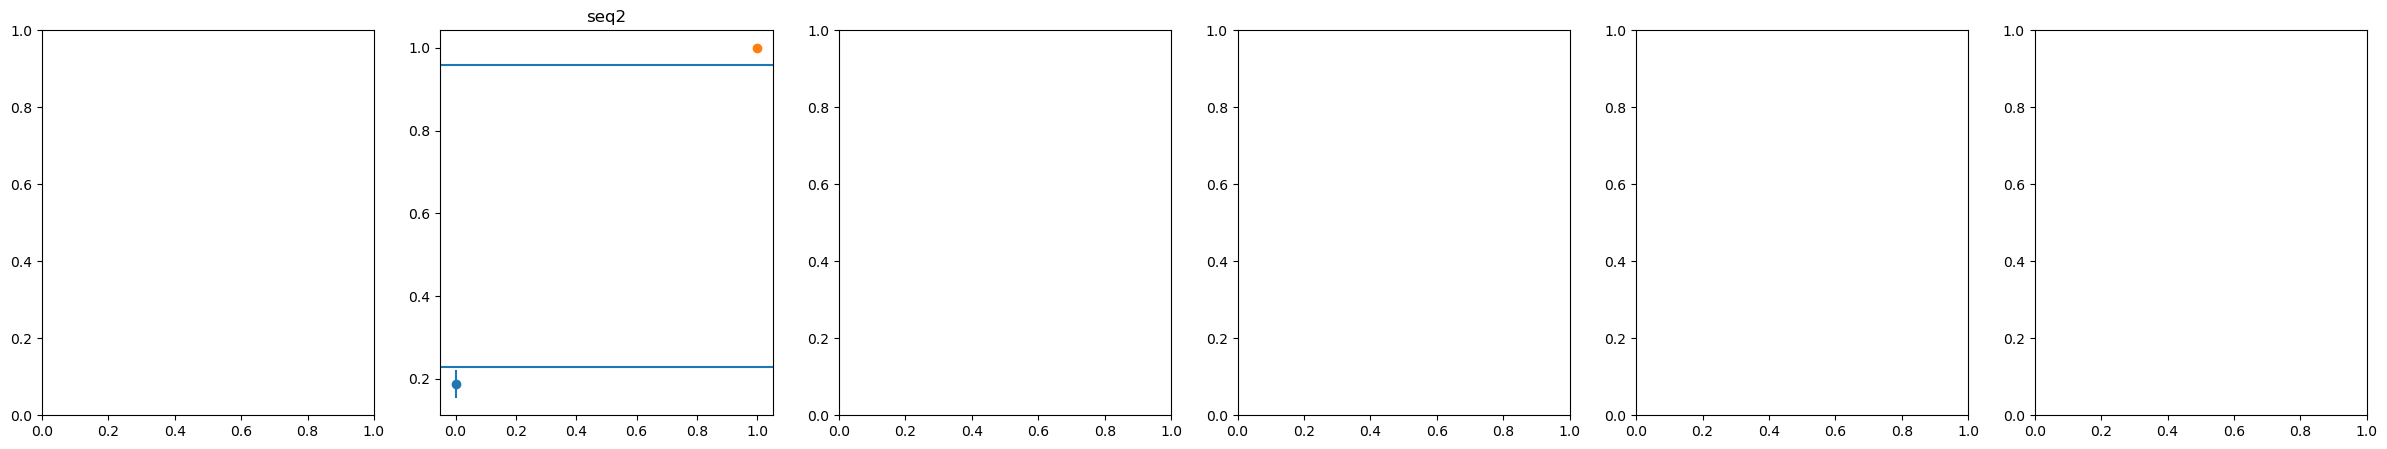

In [26]:
all_awake_mean_motif_lengths= []
all_awake_neruon_ref_df = []
per_seq_awake_neuron_time_occurances = []
fig, ax = plt.subplots(1,6, figsize=(5*6,5))
# for seq_type in range(1,7):

seq_type = 2
print(seq_type)

event_length = []
for awake_seq in awake_seq_event_dfs:
    if awake_seq.sequence_type.values[0] == seq_type:
        event_length += [max(awake_seq.timestamp) - min(awake_seq.timestamp)]
awake_mean_motif_length = np.mean(event_length)

neuron_time_occurances = awake_seqs_find_neuron_time_occurances(awake_seq_event_dfs,seq_type)

dat = []
err = []
neuron_ids = []
for neuron_id in neuron_time_occurances:
    # if it is in at least 10% of seqs
    if len(neuron_time_occurances[neuron_id]) > int(awake_seq_events[seq_type]*0.05):
        neuron_ids += [neuron_id]
        dat +=[np.mean(neuron_time_occurances[neuron_id])]
        err += [scipy.stats.sem(neuron_time_occurances[neuron_id])]


sorting_index = np.argsort(dat)
x = list(range(0,len(dat)))
for i in range(len(x)):
    ax[seq_type-1].errorbar(x[i],np.array(dat)[sorting_index][i], yerr=np.array(err)[sorting_index][i], fmt='o')

ax[seq_type-1].axhline(np.percentile(dat, 95) )
ax[seq_type-1].axhline(np.percentile(dat, 5) )
ax[seq_type-1].set_title('seq' + str(seq_type))

# save out all the relative neuron times for awake sequences to make comparison plot with slepe neurons
per_seq_awake_neuron_time_occurances += [neuron_time_occurances]

# filter out top and bottom 5%
filtered_dat = []
filtered_neuron_ids = []
for index,item in enumerate(dat):
    if item > np.percentile(dat, 10) and item < np.percentile(dat, 90):
        filtered_dat += [item]
        filtered_neuron_ids += [neuron_ids[index]]

if len(filtered_dat) > 0:

    # mak eit relative again
    rel_filtered_dat = np.array(filtered_dat) - min(filtered_dat)
    rel_filtered_dat = rel_filtered_dat/ max(rel_filtered_dat)


#     # also do this for mean length as this wlll change also 
    awake_mean_motif_length = (max(filtered_dat) - min(filtered_dat)) * awake_mean_motif_length
    all_awake_mean_motif_lengths += [awake_mean_motif_length]

    sorting_index = np.argsort(filtered_dat)
    awake_neuron_order = np.array(filtered_neuron_ids)[sorting_index]
    awake_neruon_ref_df = pd.DataFrame({'neuron_id' : awake_neuron_order, 'relative_occurance_time' : np.array(rel_filtered_dat)[sorting_index]})

    all_awake_neruon_ref_df += [awake_neruon_ref_df]
else:
    all_awake_neruon_ref_df += [[]]

In [27]:
all_awake_neruon_ref_df

[[]]

In [50]:
dat

[0.187531486146099, 1.0]

In [48]:
neuron_id

85

In [47]:
awake_seq_events[seq_type]

1

In [44]:
neuron_time_occurances

{29: [0.0,
  0.17170445004196003,
  0.23992443324934867,
  0.2558774139378986,
  0.2701511335012877,
  0.0,
  0.17170445004196003,
  0.23992443324934867,
  0.2558774139378986,
  0.2701511335012877],
 85: [1.0, 1.0]}

In [40]:
neuron_time_occurances

{29: [0.0,
  0.17170445004196003,
  0.23992443324934867,
  0.2558774139378986,
  0.2701511335012877,
  0.0,
  0.17170445004196003,
  0.23992443324934867,
  0.2558774139378986,
  0.2701511335012877],
 85: [1.0, 1.0]}

In [39]:
awake_seq_event_dfs

[        neuron  timestamp  sequence_type  seq_confidence  \
 93           1   145.5900            1.0            0.83   
 4118         4   143.0560            1.0            0.96   
 4119         4   147.7286            1.0            0.80   
 4120         4   147.7577            1.0            0.85   
 4121         4   147.7651            1.0            0.88   
 ...        ...        ...            ...             ...   
 121633     110   145.7876            1.0            0.94   
 121634     110   145.7951            1.0            0.90   
 121635     110   146.4545            1.0            0.91   
 122818     111   140.0914            1.0            0.75   
 122829     111   144.0097            1.0            0.76   
 
         sequence_type_adjusted  
 93                         1.0  
 4118                       1.0  
 4119                       1.0  
 4120                       1.0  
 4121                       1.0  
 ...                        ...  
 121633                     

In [38]:
filtered_dat

[]

In [36]:
filtered_dat

[]

In [33]:
sorted_means

(0.0, 0.5467128027677611, 0.6401384083042668, 0.8183391003453555)

In [32]:
means

[0.8183391003453555, 0.6401384083042668, 0.0, 0.5467128027677611]

In [19]:
replay_motif_data

,Unnamed: 0,cluster_seq_type,num_spikes,num_neurons,first_spike_time,event_length,last_spike_time,cluster_spike_times,cluster_neurons,spike_plotting_order,coactive_cluster_group,ordering_classification,catagory,warp_factor,task_involved


In [10]:
determine_neuron_spike_pos(sequential_replay_motif_data,i)

{}

In [7]:
neuron_spike_positions

{}

In [9]:
out_path

'Z:\\projects\\sequence_squad\\organised_data\\ppseq_data\\finalised_output\\striatum\\paper_submission\\post_sleep\\\\178_1_7_run_1207023_1350\\\\_final_analysis_output\\chunk3_13300to14300\\temporal_structure_analysis\\'

In [5]:
# only take sequential replay
sequential_replay_motif_data = replay_motif_data[replay_motif_data.catagory == 'forward']
sequential_replay_motif_data = sequential_replay_motif_data.reset_index(drop = True)

forward_neuron_spike_positions_all_seqs = []
for i in range(1,7):
    forward_neuron_spike_positions_all_seqs += [determine_neuron_spike_pos(sequential_replay_motif_data,i)]


# only take sequential replay
sequential_replay_motif_data = replay_motif_data[replay_motif_data.catagory == 'reverse']
sequential_replay_motif_data = sequential_replay_motif_data.reset_index(drop = True)

reverse_neuron_spike_positions_all_seqs = []
for i in range(1,7):
    reverse_neuron_spike_positions_all_seqs += [determine_neuron_spike_pos(sequential_replay_motif_data,i)]



fig, axs = plt.subplots(1,6, figsize=(8,3.5))

for i, ax in enumerate(axs):
    neuron_spike_positions = forward_neuron_spike_positions_all_seqs[i]
    if len(neuron_spike_positions) > 1:
        means = []
        std_devs = []
        neurs = []

        for neuron in neuron_spike_positions:
            neurs+=[neuron]
            means+=[np.mean(neuron_spike_positions[neuron])]
            std_devs+=[scipy.stats.sem(neuron_spike_positions[neuron])]

        #Sort means and std_devs together based on means
        sorted_data = sorted(zip(means, std_devs))
        sorted_means, sorted_std_devs = zip(*sorted_data)

    #Plot means with error bars
    ax.errorbar(range(len(means)), sorted_means, yerr=sorted_std_devs, fmt='o', capsize=0, color = colors[i+1])

#     #Add labels and title
#     ax.set_ylabel('Mean relative position in replay')

    ax.set_title(mouse)
    
    ax.set_ylim(-0.1,1.1)

#                         SaveFig(mouse+ '_neuron_mean_relative_pos.pdf',r'Z:\projects\Emmett\Documents\replay_analysis_filtering_options\sequentiality_forward_examples\\')
SaveFig(mouse+ '_neuron_mean_relative_pos.pdf',r'D:\\')


fig, axs = plt.subplots(1,6, figsize=(8,3.5))

for i, ax in enumerate(axs):
    neuron_spike_positions = reverse_neuron_spike_positions_all_seqs[i]
    if len(neuron_spike_positions) > 1:
        means = []
        std_devs = []
        neurs = []

        for neuron in neuron_spike_positions:
            neurs+=[neuron]
            means+=[np.mean(neuron_spike_positions[neuron])]
            std_devs+=[scipy.stats.sem(neuron_spike_positions[neuron])]

        #Sort means and std_devs together based on means
        sorted_data = sorted(zip(means, std_devs))
        sorted_means, sorted_std_devs = zip(*sorted_data)

    #Plot means with error bars
    ax.errorbar(range(len(means)), sorted_means, yerr=sorted_std_devs, fmt='o', capsize=0, color = colors[i+1])

    #Add labels and title
#     ax.set_ylabel('Mean relative position in replay')

    ax.set_title(mouse)

#                         SaveFig(mouse+ '_neuron_mean_relative_pos.pdf',r'Z:\projects\Emmett\Documents\replay_analysis_filtering_options\sequentiality_reverse_examples\\')
# SaveFig(mouse+ '_neuron_mean_relative_pos.png',r'Z:\projects\Emmett\Documents\replay_analysis_filtering_options\sequentiality_reverse_examples\\')
SaveFig(mouse+ '_neuron_mean_relative_pos_reverse.pdf',r'D:\\')

C:\Users\Emmett\anaconda3\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Emmett\anaconda3\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


103.0
83.0


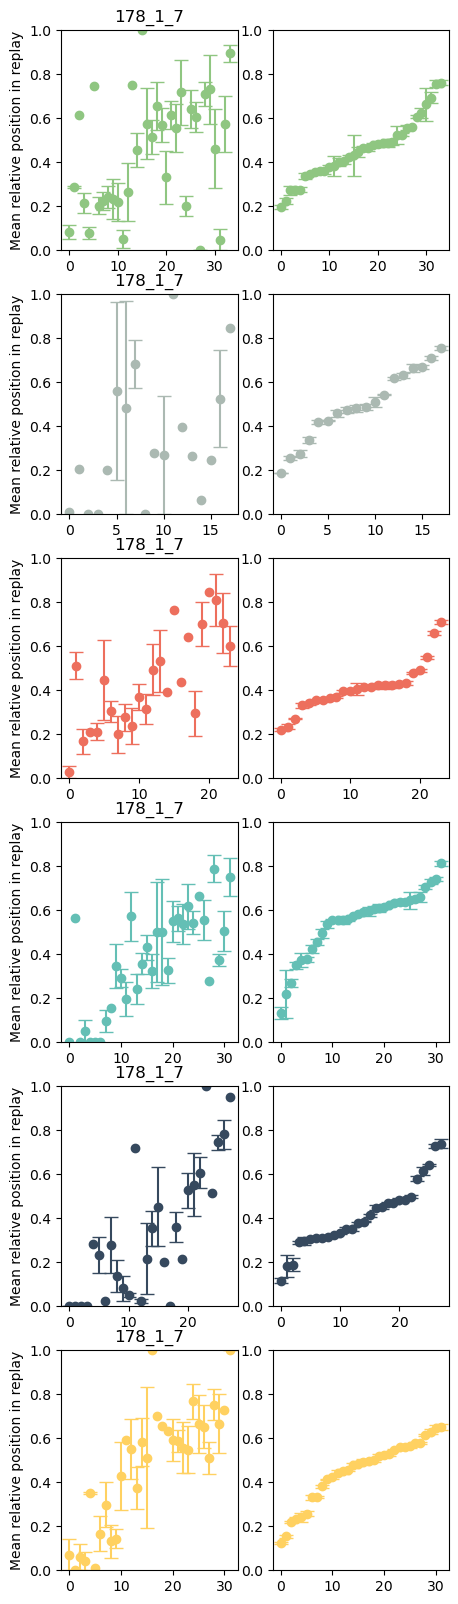

In [410]:
fig, axs = plt.subplots(6,2, figsize=(5,20))

for i, ax in enumerate(axs):
    
    neuron_spike_positions = forward_neuron_spike_positions_all_seqs[i]
    if len(neuron_spike_positions) > 1:
        means = []
        std_devs = []
        neurs = []

        for neuron in neuron_spike_positions:
            neurs+=[neuron]
            means+=[np.mean(neuron_spike_positions[neuron])]
            std_devs+=[scipy.stats.sem(neuron_spike_positions[neuron])]

#     #Sort means and std_devs together based on means
#     sorted_data = sorted(zip(means, std_devs,neurs))
#     sorted_means, sorted_std_devs,sorted_neurs = zip(*sorted_data)

#     #Plot means with error bars
#     ax[0].errorbar(range(len(means)), sorted_means, yerr=sorted_std_devs, fmt='o', capsize=5, color = colors[i+1])



    sleep_neuron_rel_pos = []
    awake_neurons_rel_pos = []


    neuron_spike_positions = forward_neuron_spike_positions_all_seqs[i]
    if len(neuron_spike_positions) > 1: 
        means = []
        std_devs = []
        neurs = []
        for neuron in neuron_spike_positions:
            neurs+=[neuron]
            means+=[np.mean(neuron_spike_positions[neuron])]
            std_devs+=[scipy.stats.sem(neuron_spike_positions[neuron])]

    awake_means = []
    awake_sems =[]
    awake_neurs = []
    for neur in neurs:
        found = False
        for key in per_seq_awake_neuron_time_occurances[i]:
            if key == neur:
                found = True
                awake_means += [np.mean(per_seq_awake_neuron_time_occurances[i][key])]
                awake_sems+= [scipy.stats.sem(per_seq_awake_neuron_time_occurances[i][key])]
                awake_neurs += [neur]

        if found == False:
            print(neur)

#     Sort means and std_devs together based on means
    sorted_data = sorted(zip(awake_means, awake_sems,awake_neurs,means,std_devs,neurs))
    sorted_awake_means, sorted_awake_sems,sorted_awake_neurs,sorted_means, sorted_std_devs,sorted_neurs = zip(*sorted_data)

    #Plot means with error bars
    ax[0].errorbar(range(len(sorted_means)), sorted_means, yerr=sorted_std_devs, fmt='o', capsize=5, color = colors[i+1])



#     #Sort means and std_devs together based on means
#     sorted_data = sorted(zip(awake_means, awake_sems))
#     sorted_means, sorted_std_devs = zip(*sorted_data)

    #Plot means with error bars
    ax[1].errorbar(range(len(sorted_awake_means)), sorted_awake_means, yerr=sorted_awake_sems, fmt='o', capsize=5, color = colors[i+1])

#     Add labels and title
    ax[0].set_ylabel('Mean relative position in replay')

    ax[0].set_title(mouse)
    ax[1].set_ylim(0,1)
    ax[0].set_ylim(0,1)

In [333]:
forward_neuron_spike_positions_all_seqs[seq_type]

{2.0: [0.056241426613183196,
  0.0152905198782635,
  0.08504801097116448,
  0.3735676088631729,
  0.187978142079023,
  0.328996282528499,
  0.0,
  0.0,
  0.2650375939865129,
  0.0,
  0.2750373692075086],
 13.0: [0.8600823045246696,
  1.0,
  0.2723174030638765,
  0.3851141078843725,
  0.5391400220511633,
  0.7367119901124644,
  0.7654698242951027,
  0.7103825136618268,
  0.5479452054675052,
  0.06976744186210473,
  0.44247787611118056,
  0.38757154537961364,
  0.0,
  0.3565217391178841,
  0.9360902255629296,
  0.67110036275676,
  0.0,
  0.5097159940202155],
 42.0: [1.0,
  0.3522379760906571,
  0.8831312017643337,
  1.0,
  0.5297397769498504,
  0.7661488143900426,
  0.7649489019352878,
  0.851269649336415],
 58.0: [0.7969821673539239,
  0.6721311475437537,
  0.5947955390336354,
  0.6769230769272284,
  0.1749502982108614],
 102.0: [0.6639231824423941,
  0.4627831715269414,
  0.6298701298596796,
  0.4766966475890995,
  0.7130434782555398],
 116.0: [0.0,
  0.0,
  0.0,
  0.4430863254388367,


In [336]:
## if neuron appears in replay

## find mean and sem 



{2: [0.309116682909542,
  0.3667050589173385,
  0.37822273411889784,
  0.3871710817754939,
  0.3974483919553468,
  0.40267564454682375,
  0.4406839727119695,
  0.4597324355453175,
  0.46584566315229914,
  0.503499601311243,
  0.5131567289802427,
  0.5166120315407104,
  0.519624346593426,
  0.522902454150793,
  0.5276867192345175,
  0.5301674492779304,
  0.5335341543368477,
  0.5362806768849118,
  0.5392929919376274,
  0.5425710994949943,
  0.5582528572694249,
  0.5740232125454061,
  0.5791618676353326,
  0.06935463420819066,
  0.12412831241283082,
  0.1435273234436414,
  0.1568403702294915,
  0.1679979713452515,
  0.17661975402561175,
  0.18105743628756157,
  0.19259541016863185,
  0.19639913782173146,
  0.2145302396348422,
  0.22822365918600193,
  0.23468999619627212,
  0.24115633320654234,
  0.2658805629516924,
  0.2928870292887028,
  0.31406111322429264,
  0.3338404970204129,
  0.3373906428299731,
  0.34258907062254346,
  0.3491821985545833,
  0.3542538354253834,
  0.423101305946494

In [332]:
len(per_seq_awake_neuron_time_occurances[seq_type])

65

In [301]:
rel_filtered_dat

array([0.43224304, 0.84473273, 0.85645776, 0.38804645, 0.99121305,
       0.64498579, 0.01858129, 0.06373849, 0.81354307, 0.22078153,
       0.63469152, 0.51054471, 0.59512377, 0.8155134 , 0.65503036,
       0.70338441, 0.8051746 , 0.54533744, 0.92031839, 0.9523458 ,
       0.77766115, 0.60387547, 0.72441904, 0.85437935, 0.61743129,
       0.7147179 , 0.88345669, 0.22589626, 0.34991339, 0.45715142,
       0.52625256, 0.71946305, 0.        , 0.36320528, 1.        ,
       0.79881661, 0.71441082, 0.50674436, 0.33519692, 0.81951957,
       0.02953738, 0.8077245 , 0.87101171, 0.9862584 , 0.58122693,
       0.63927885])

In [ ]:
### make the same example plots for awake data!

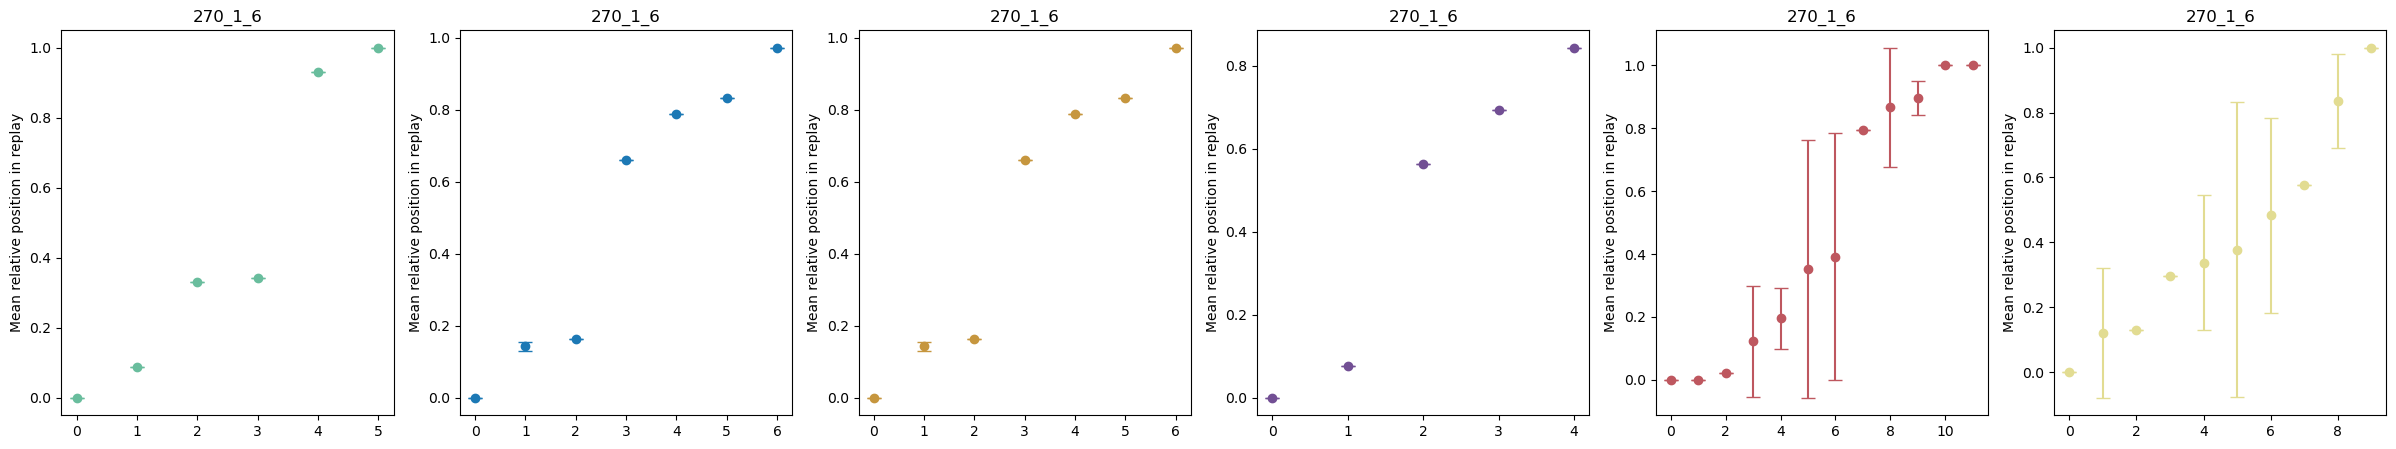

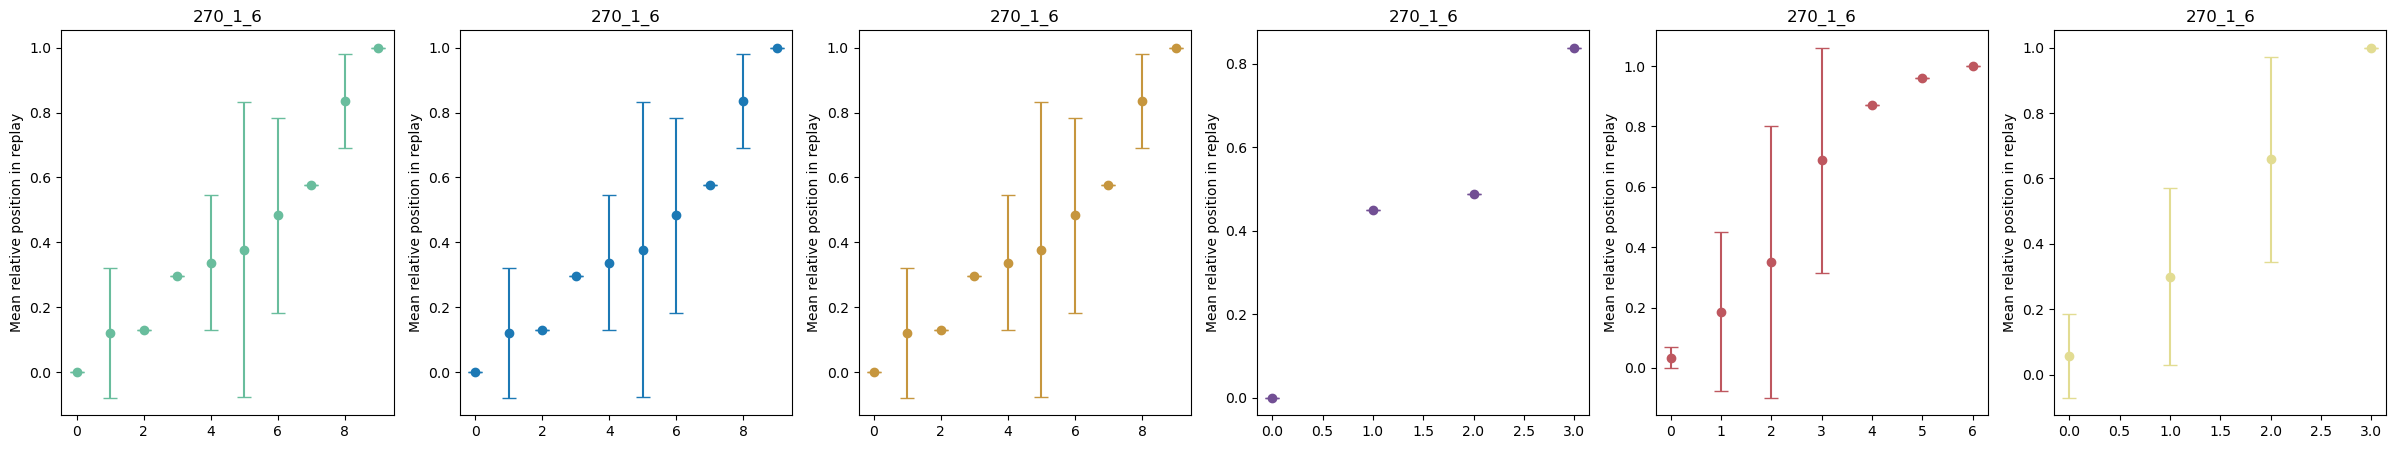

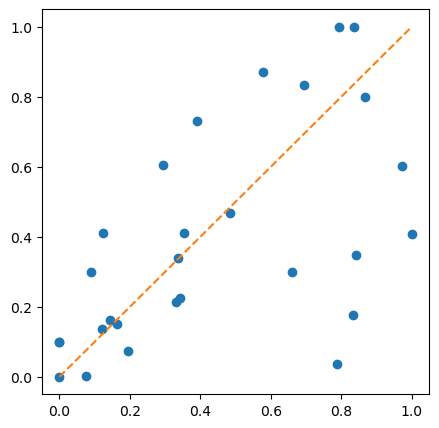

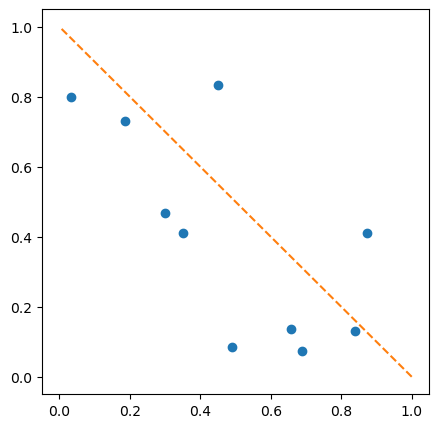

In [292]:
################
# for each neuron what is its average rleative position in the replay (first to last spike)
# for each neuron, what is it relative position in replay compared to relative awake

##only take sequentail forward replay! 


def normalize_times(times):
    min_time = min(times)
    max_time = max(times)
    time_range = max_time - min_time

    normalized_times = [(t - min_time) / time_range for t in times]
    return normalized_times

def replace_repeats_with_string(numbers):
    seen = set()
    result = []

    for num in numbers:
        if num in seen:
            result.append('repeat')
        else:
            result.append(num)
            seen.add(num)

    return result




def determine_neuron_spike_pos(replay_motif_data,seq_type):
    neuron_spike_positions = {}
    for i in range(len(replay_motif_data)):

        if replay_motif_data.cluster_seq_type[i] == seq_type:

            replay_neurons = ast.literal_eval(replay_motif_data.cluster_neurons[i])
            replay_spikes = np.array(ast.literal_eval(replay_motif_data.cluster_spike_times[i]))

            norm_replay_spikes = normalize_times(replay_spikes)

            replay_neurons_fspike_only = replace_repeats_with_string(replay_neurons)

            for index,neur_id in enumerate(replay_neurons_fspike_only):
                if not neur_id == 'repeat':
                    if neur_id in neuron_spike_positions:
                        neuron_spike_positions[neur_id] += [norm_replay_spikes[index]]

                    else:
                        neuron_spike_positions[neur_id] = [norm_replay_spikes[index]]
    return neuron_spike_positions


# only take sequential replay
sequential_replay_motif_data = replay_motif_data[replay_motif_data.catagory == 'forward']
sequential_replay_motif_data = sequential_replay_motif_data.reset_index(drop = True)

forward_neuron_spike_positions_all_seqs = []
for i in range(1,7):
    forward_neuron_spike_positions_all_seqs += [determine_neuron_spike_pos(sequential_replay_motif_data,i)]


# only take sequential replay
sequential_replay_motif_data = replay_motif_data[replay_motif_data.catagory == 'reverse']
sequential_replay_motif_data = sequential_replay_motif_data.reset_index(drop = True)

reverse_neuron_spike_positions_all_seqs = []
for i in range(1,7):
    reverse_neuron_spike_positions_all_seqs += [determine_neuron_spike_pos(sequential_replay_motif_data,i)]



fig, axs = plt.subplots(1,6, figsize=(30,5))

for i, ax in enumerate(axs):
    neuron_spike_positions = forward_neuron_spike_positions_all_seqs[i]
    if len(neuron_spike_positions) > 1:
        means = []
        std_devs = []
        neurs = []

        for neuron in neuron_spike_positions:
            neurs+=[neuron]
            means+=[np.mean(neuron_spike_positions[neuron])]
            std_devs+=[np.std(neuron_spike_positions[neuron])]

        #Sort means and std_devs together based on means
        sorted_data = sorted(zip(means, std_devs))
        sorted_means, sorted_std_devs = zip(*sorted_data)

    #Plot means with error bars
    ax.errorbar(range(len(means)), sorted_means, yerr=sorted_std_devs, fmt='o', capsize=5, color = colors[i+1])

    #Add labels and title
    ax.set_ylabel('Mean relative position in replay')

    ax.set_title(mouse)

#                         SaveFig(mouse+ '_neuron_mean_relative_pos.pdf',r'Z:\projects\Emmett\Documents\replay_analysis_filtering_options\sequentiality_forward_examples\\')
# SaveFig(mouse+ '_neuron_mean_relative_pos.png',r'Z:\projects\Emmett\Documents\replay_analysis_filtering_options\sequentiality_forward_examples\\')


fig, axs = plt.subplots(1,6, figsize=(30,5))

for i, ax in enumerate(axs):
    neuron_spike_positions = reverse_neuron_spike_positions_all_seqs[i]
    if len(neuron_spike_positions) > 1:
        means = []
        std_devs = []
        neurs = []

        for neuron in neuron_spike_positions:
            neurs+=[neuron]
            means+=[np.mean(neuron_spike_positions[neuron])]
            std_devs+=[np.std(neuron_spike_positions[neuron])]

        #Sort means and std_devs together based on means
        sorted_data = sorted(zip(means, std_devs))
        sorted_means, sorted_std_devs = zip(*sorted_data)

    #Plot means with error bars
    ax.errorbar(range(len(means)), sorted_means, yerr=sorted_std_devs, fmt='o', capsize=5, color = colors[i+1])

    #Add labels and title
    ax.set_ylabel('Mean relative position in replay')

    ax.set_title(mouse)

#                         SaveFig(mouse+ '_neuron_mean_relative_pos.pdf',r'Z:\projects\Emmett\Documents\replay_analysis_filtering_options\sequentiality_reverse_examples\\')
# SaveFig(mouse+ '_neuron_mean_relative_pos.png',r'Z:\projects\Emmett\Documents\replay_analysis_filtering_options\sequentiality_reverse_examples\\')


############# neuron relative position in awake and sleep 

sleep_neuron_rel_pos = []
awake_neurons_rel_pos = []


for seq_type in range(6):
    neuron_spike_positions = forward_neuron_spike_positions_all_seqs[seq_type]
    if len(neuron_spike_positions) > 1:
        awake_neruon_ref_df

        means = []
        std_devs = []
        neurs = []
        for neuron in neuron_spike_positions:
            neurs+=[neuron]
            means+=[np.mean(neuron_spike_positions[neuron])]
            std_devs+=[np.std(neuron_spike_positions[neuron])]


        for i,n in enumerate(neurs):
            if n in all_awake_neruon_ref_df[seq_type].neuron_id.values:
                awake_neruon_ref_df.neuron_id == n
                awake_neurons_rel_pos += [all_awake_neruon_ref_df[seq_type][all_awake_neruon_ref_df[seq_type].neuron_id == n].relative_occurance_time.values[0]]
                sleep_neuron_rel_pos += [means[i]]


fig, axs = plt.subplots(1,1, figsize=(5,5))      
axs.plot(sleep_neuron_rel_pos,awake_neurons_rel_pos,'o')
x = np.linspace(0, 1, 10)  # Example x values
y = x  # Since x equals y, y values are the same as x values
axs.plot(x,y,'--')

#                     SaveFig(mouse+ '_neuron_mean_relative_pos.pdf',r'Z:\projects\Emmett\Documents\replay_analysis_filtering_options\sequentiality_reverse_examples\\')
# SaveFig(mouse+ '_neuron_mean_relative_pos.png',r'Z:\projects\Emmett\Documents\replay_analysis_filtering_options\sequentiality_forwards_examples\\')

# np.save(out_path + 'neuron_rel_forward_replay_positions.npy',np.array(sleep_neuron_rel_pos))
# np.save(out_path + 'neuron_rel_awake_positions_forwards.npy',np.array(awake_neurons_rel_pos))  

############################################

sleep_neuron_rel_pos = []
awake_neurons_rel_pos = []


for seq_type in range(6):
    neuron_spike_positions = reverse_neuron_spike_positions_all_seqs[seq_type]
    if len(neuron_spike_positions) > 1:
        awake_neruon_ref_df

        means = []
        std_devs = []
        neurs = []
        for neuron in neuron_spike_positions:
            neurs+=[neuron]
            means+=[np.mean(neuron_spike_positions[neuron])]
            std_devs+=[np.std(neuron_spike_positions[neuron])]


        for i,n in enumerate(neurs):
            if n in all_awake_neruon_ref_df[seq_type].neuron_id.values:
                awake_neruon_ref_df.neuron_id == n
                awake_neurons_rel_pos += [all_awake_neruon_ref_df[seq_type][all_awake_neruon_ref_df[seq_type].neuron_id == n].relative_occurance_time.values[0]]
                sleep_neuron_rel_pos += [means[i]]



fig, axs = plt.subplots(1,1, figsize=(5,5))      
axs.plot(sleep_neuron_rel_pos,awake_neurons_rel_pos,'o')
x = np.linspace(0, 1, 10)  # Example x values
y = 1-x  # Since x equals y, y values are the same as x values
axs.plot(y,x,'--')

#                     SaveFig(mouse+ '_neuron_mean_relative_pos.pdf',r'Z:\projects\Emmett\Documents\replay_analysis_filtering_options\sequentiality_reverse_examples\\')
# SaveFig(mouse+ '_neuron_mean_relative_pos.png',r'Z:\projects\Emmett\Documents\replay_analysis_filtering_options\sequentiality_reversed_examples\\')

# np.save(out_path + 'neuron_rel_reverse_replay_positions.npy',np.array(sleep_neuron_rel_pos))
# np.save(out_path + 'neuron_rel_awake_positions_reverse.npy',np.array(awake_neurons_rel_pos))    

In [9]:
reverse_neuron_spike_positions_all_seqs

[{}, {}, {}, {}, {}, {}]

In [8]:
neuron_spike_positions

{}

In [3]:
####  TO DO
##### change this so that teh first thing that is done is working out type (fragmented sequential etc.) then mark these out in data frames but only apply analysis to sequential 
# then change across animals anlysis (both types) so that they combine (but keep seperate) expert and learning . And so that only sequential stuff is looked at!

In [4]:
# single event temporal sequece analysis: how doe sit relate to latent information. 
# for each event, plot which neurons are involved and what order they occur, see how this matches what we see in awake behaviour.
# load awake behav. filter for each sequence or load in the fset fro the latent analysis. 
# see if the temporal ofsets and neuron types are consitent in rpelay and consistent with awake
# use this to determine reverse and stuff? # save these outsomehwre? # do these correspond properlyh with warp values?

In [282]:
len(neuron_spike_positions)

0

In [280]:
means

[]

In [277]:
forward_neuron_spike_positions_all_seqs[i]

{}

In [276]:
i

1

In [268]:
neuron_spike_positions

{}

In [267]:
means

[]

In [266]:
sorted_data

[]

# produce example plots 

In [378]:
import numpy as np

def convert_string_to_array(array_string):
    # Remove the brackets from the string
    array_string = array_string.strip('[]')

    # Split the string into individual elements
    elements = array_string.split()

    # Convert the elements to float values (assuming the array contains floats)
    array = np.array([float(elem) for elem in elements])

    return array




In [379]:
# make this into a heatmap plot wiht a regression line (with raster - compared to awake raster for motif)

# do the same for the other flavours 


,seq_type,regression_line,filt_rel_spike_times,awake_rel_occurance_times,slope,reactivation_ID,task_involved
0,1,"[0.702286897410304, 0.7168449722054617, 0.7317...","[0.6189999999999145, 0.6423999999999523, 0.666...","[0.7609547827822231, 0.7609547827822231, 0.760...",0.622140,0,1
1,1,"[0.4436185818498387, 0.3169783155261334, 0.965...","[0.17930000000023938, 0.22280000000000655, 0.0...","[0.31974578992986136, 0.31974578992986136, 0.8...",-2.911270,1,1
2,1,"[0.8024155611174514, 0.8438875228509992, 0.874...","[0.0, 0.03569999999990614, 0.06239999999979773...","[0.8265026975784936, 0.8265026975784936, 0.826...",1.161680,5,1
3,1,"[0.4050065395176375, 0.6255423223054613, 0.892...","[0.628400000000056, 0.34429999999974825, 0.0, ...","[0.3743589718494362, 0.6268234535757661, 0.760...",-0.776261,6,1
4,1,"[0.40950100297828307, 0.4614407752103361, 0.47...","[0.0, 0.17250000000012733, 0.21019999999998618...","[0.4940868314168806, 0.4940868314168806, 0.494...",0.301100,7,1
...,...,...,...,...,...,...,...
129,6,"[0.7555243978187807, 0.7810135006920024, 0.916...","[0.0, 0.014000000000123691, 0.0882999999998901...","[0.7229917801727229, 0.7229917801727229, 0.781...",1.820650,252,1
130,6,"[0.8418488283881062, 0.8566015594717803, 0.834...","[0.0027000000000043656, 0.008100000000013097, ...","[0.7876798982317694, 0.7876798982317694, 0.901...",2.731987,258,1
131,6,"[0.8281881584174313, 0.5346004520750576, 0.601...","[0.04930000000013024, 0.0, 0.01119999999991705...","[0.78128082664317, 0.4820488668627095, 0.46607...",5.955126,259,1
132,6,"[0.7772495414682056, 0.7510336823503064, 0.847...","[0.12100000000009459, 0.13710000000037326, 0.0...","[0.7229917801727229, 0.7229917801727229, 0.950...",-1.628314,260,1


In [ ]:
### plot the whole event, then underneath plot the regression

In [398]:
path = r'Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\striatum\New_Post_sleep\178_1_7_run_1207023_1350\analysis_output\chunk1_8300to10000\temporal_structure_analysis\\'
#chunk2_10500to11200
#chunk3_13300to14300


awake_path = r'Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\178_1_7_run_2701023_1720\analysis_output\reordered_recolored\\' 


# + 'ordering.pkl'




In [400]:
import pickle
with open(PP_PATH + file + "\\analysis_output\\" + "spikes_seq_type_adjusted.pickle", "rb") as input_file:
    unmasked_spikes_df = pickle.load(input_file)

,Unnamed: 0,seq_0_counts,seq_1_counts,seq_2_counts,seq_3_counts,seq_4_counts,seq_5_counts
0,0,0,0,0,0,0,0
1,1,0,0,0,0,14,0
2,2,0,0,0,0,0,0
3,3,0,0,0,14,84,17
4,4,0,0,0,0,0,0
...,...,...,...,...,...,...,...
2069,2069,0,0,0,0,0,0
2070,2070,0,0,0,0,0,0
2071,2071,0,0,0,0,0,0
2072,2072,0,0,0,0,0,0


In [386]:
# load replay data
regression_df = pd.read_csv(path  + 'regression_df.csv')

stationary_regression_df = pd.read_csv(path  + 'stationary_regression_df.csv')

fragmented_regression_df = pd.read_csv(path  + 'fragmented_regression_df.csv')

filtered_replay_clusters_df = pd.read_csv(r'Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\striatum\New_Post_sleep\178_1_7_run_1207023_1350\analysis_output\chunk1_8300to10000\\' + 'filtered_replay_clusters_df.csv')




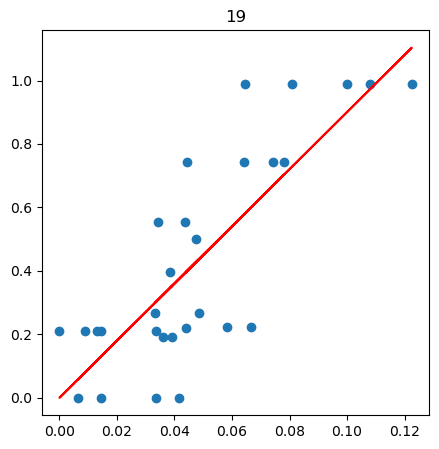

In [390]:
fivex_events = regression_df[(regression_df.warp_factor > 3) * (regression_df.warp_factor < 5)]
fivex_events =fivex_events.reset_index()
for i in range(len(fivex_events.filt_rel_spike_times)):
    if i == 19:
        fig, ax = plt.subplots(1, 1,figsize=(5, 5))
        x = convert_string_to_array(fivex_events.filt_rel_spike_times[i])
        y = convert_string_to_array(fivex_events.awake_rel_occurance_times[i])
        ax.plot(x,y,'o')
        r_line = convert_string_to_array(fivex_events.regression_line[i])
        ax.plot(x,r_line,'-', c = 'r')
        ax.set_title(str(i))

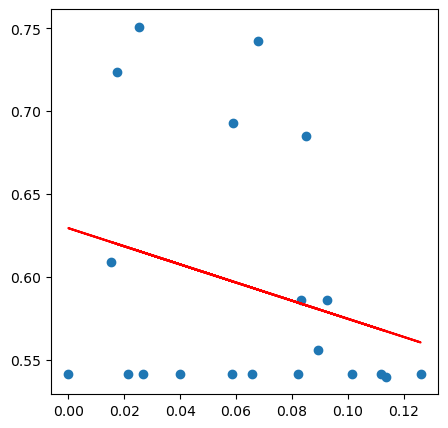

In [388]:
for i in range(len(fragmented_regression_df.filt_rel_spike_times)):
    i = 500
    fig, ax = plt.subplots(1, 1,figsize=(5, 5))
    x = convert_string_to_array(fragmented_regression_df.filt_rel_spike_times[i])
    y = convert_string_to_array(fragmented_regression_df.awake_rel_occurance_times[i])
    ax.plot(x,y,'o')
    r_line = convert_string_to_array(fragmented_regression_df.regression_line[i])
    ax.plot(x,r_line,'-', c = 'r')
    break


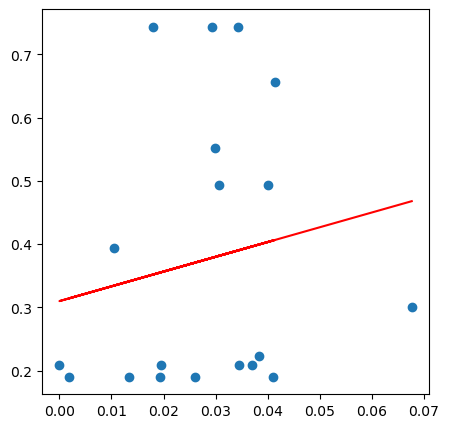

In [384]:
for i in range(len(fragmented_regression_df.filt_rel_spike_times)):
    i = 200
    fig, ax = plt.subplots(1, 1,figsize=(5, 5))
    x = convert_string_to_array(fragmented_regression_df.filt_rel_spike_times[i])
    y = convert_string_to_array(fragmented_regression_df.awake_rel_occurance_times[i])
    ax.plot(x,y,'o')
    r_line = convert_string_to_array(fragmented_regression_df.regression_line[i])
    ax.plot(x,r_line,'-', c = 'r')
    break


In [1232]:
fragmented_regression_df

,Unnamed: 0,seq_type,regression_line,filt_rel_spike_times,awake_rel_occurance_times,reactivation_ID,task_involved
0,0,1,[0.30960199 0.26697186 0.29788684 0.33596108 0...,[0.0541 0.0279 0.0469 0.0703 0.0599 0.0474 0.0...,[0.3011993 0.32889487 0.32889487 0.22324512 0...,0,1
1,1,1,[0.30656462 0.33924878 0.41115393 0.43076443],[0.0038 0.0028 0.0006 0. ],[0.22324512 0.49367951 0.21816739 0.55263975],1,1
2,2,1,[0.38161697 0.38687794 0.36583407 0.37284869 0...,[0.0222 0.0234 0.0186 0.0202 0.0276 0. 0.0...,[0.49367951 0.98795662 0.20873064 0.20873064 0...,5,1
3,3,1,[0.34686502 0.3202169 0.33729902 0.37180492 0...,[0.026 0.0104 0.0204 0.0406 0.058 0.0637 0.0...,[0.22324512 0.53129941 0.53129941 0.53129941 0...,7,1
4,4,1,[0.38302928 0.47880548 0.4481571 0.44870439],[0. 0.0175 0.0119 0.012 ],[0.3011993 0.3011993 0.49941514 0.65688252],9,1
...,...,...,...,...,...,...,...
864,864,6,[0.72106468 0.72334794 0.70993376 0.68966978 0...,[0.0107 0.0099 0.0146 0.0217 0.0125 0.0159 0.0...,[0.36320528 0.85645776 0.85645776 0.85645776 0...,1533,1
865,865,6,[0.76070544 0.77537182 0.71003977 0.87270324 0...,[0.0084 0.0073 0.0122 0. 0.008 0.0133 0.0...,[0.43224304 0.64498579 0.8051746 0.9523458 0...,1534,1
866,866,6,[0.84320922 0.84466391 0.84533578 0.84561932 0...,[0.023 0.0466 0.0575 0.0621 0.0398 0. 0.0...,[0.85645776 0.85645776 0.85645776 0.85645776 0...,1538,1
867,867,6,[0.73264379 0.74446406 0.76928662 0.785835 0...,[0. 0.001 0.0031 0.0045 0.0074 0.0089 0.0...,[0.51054471 0.8051746 0.8051746 0.9523458 0...,1540,1


,Unnamed: 0,seq_type,regression_line,filt_rel_spike_times,awake_rel_occurance_times,reactivation_ID,task_involved
0,0,1,[0.30960199 0.26697186 0.29788684 0.33596108 0...,[0.0541 0.0279 0.0469 0.0703 0.0599 0.0474 0.0...,[0.3011993 0.32889487 0.32889487 0.22324512 0...,0,1
1,1,1,[0.30656462 0.33924878 0.41115393 0.43076443],[0.0038 0.0028 0.0006 0. ],[0.22324512 0.49367951 0.21816739 0.55263975],1,1
2,2,1,[0.38161697 0.38687794 0.36583407 0.37284869 0...,[0.0222 0.0234 0.0186 0.0202 0.0276 0. 0.0...,[0.49367951 0.98795662 0.20873064 0.20873064 0...,5,1
3,3,1,[0.34686502 0.3202169 0.33729902 0.37180492 0...,[0.026 0.0104 0.0204 0.0406 0.058 0.0637 0.0...,[0.22324512 0.53129941 0.53129941 0.53129941 0...,7,1
4,4,1,[0.46611606 0.39412935 0.33675649 0.3145651 0...,[0.0208 0.0341 0.0447 0.0488 0.0613 0.0258 0.0...,[0.49367951 0.49367951 0.49367951 0.49367951 0...,8,1
...,...,...,...,...,...,...,...
984,984,6,[0.76070544 0.77537182 0.71003977 0.87270324 0...,[0.0084 0.0073 0.0122 0. 0.008 0.0133 0.0...,[0.43224304 0.64498579 0.8051746 0.9523458 0...,1535,1
985,985,6,[0.84320922 0.84466391 0.84533578 0.84561932 0...,[0.023 0.0466 0.0575 0.0621 0.0398 0. 0.0...,[0.85645776 0.85645776 0.85645776 0.85645776 0...,1539,1
986,986,6,[0.73264379 0.74446406 0.76928662 0.785835 0...,[0. 0.001 0.0031 0.0045 0.0074 0.0089 0.0...,[0.51054471 0.8051746 0.8051746 0.9523458 0...,1541,1
987,987,6,[0.77219036 0.776451 0.77153487 0.77972843 0...,[2.0e-04 1.5e-03 0.0e+00 2.5e-03 4.5e-03 1.0e-04],[0.8051746 0.8051746 0.77766115 0.77766115 0...,1542,1


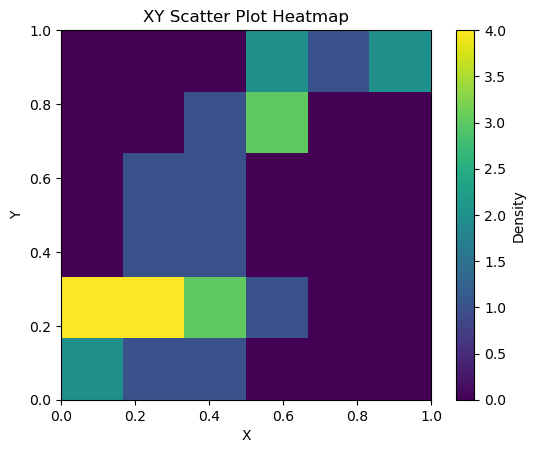

In [395]:
heatmap, xedges, yedges = np.histogram2d(x/max(x), y, bins=6, range=[[0, 1], [0, 1]])

plt.imshow(heatmap.T, origin='lower', extent=[0, 1, 0, 1], cmap='viridis')
plt.colorbar(label='Density')  # Add a color bar with the label "Density"
plt.xlabel('X')
plt.ylabel('Y')
plt.title('XY Scatter Plot Heatmap')
plt.show()




In [1177]:
y

array([0.        , 0.        , 0.        , 0.        , 0.22324512,
       0.22324512, 0.55316418, 0.74358498, 0.74358498, 0.74358498,
       0.74358498, 0.21816739, 0.98795662, 0.98795662, 0.98795662,
       0.98795662, 0.98795662, 0.20873064, 0.20873064, 0.20873064,
       0.20873064, 0.20873064, 0.19037368, 0.19037368, 0.55263975,
       0.26721771, 0.26721771, 0.39447473, 0.49905098])

In [942]:
fivex_events

,index,Unnamed: 0,seq_type,regression_line,filt_rel_spike_times,awake_rel_occurance_times,slope,reactivation_ID,task_involved,warp_factor
0,4,4,1,[0.1596982 0.32337093 0.498904 0.55583364 0...,[0.0022 0.016 0.0308 0.0356 0. ],[0. 0.49367951 0.49367951 0.49367951 0...,11.860342,11,1,4.277826
1,15,15,1,[0.57714971 0.62255089 0.86408512 0.0768288 0...,[0.0551 0.0601 0.0867 0. 0.0189 0.0329 0.0...,[0.98795662 0.73857789 0.73857789 0.19037368 0...,9.080234,35,1,3.275088
2,17,17,1,[0.49132361 0.4123028 0.32393546 0.27635304 0...,[0.0462 0.0369 0.0265 0.0209 0. 0.0191 0.0...,[0.49367951 0.53129941 0.49941514 0.20873064 0...,8.496860,43,1,3.064675
3,22,22,1,[-0.08112318 0.08569826 0.14160119 0.200166...,[0. 0.0188 0.0251 0.0317 0.0098 0.018 0.0...,[0. 0. 0. 0. 0...,8.873481,67,1,3.200515
4,26,26,1,[-0.0074322 -0.11366953 0.0494141 0.113715...,[0.0114 0. 0.0175 0.0244 0.0351 0.0475 0.0...,[0.3011993 0. 0. 0. 0...,9.319064,80,1,3.361230
5,49,49,1,[0.46340605 0.30013132 0.14781462 0.53901649 0...,[0.0288 0.0139 0. 0.0357 0.0155 0.0165 0.0...,[0.337143 0.49941514 0.21816739 0.65688252 0...,10.958036,147,1,3.952379
6,53,53,1,[0.09792588 0.34814322 0.25222657 0.64590185],[0. 0.03 0.0185 0.0657],[0. 0.57339038 0.21816739 0.55263975],8.340578,151,1,3.008306
7,54,54,1,[0.39274106 0.72778044 0.88658523 0.29590887],[0.01 0.0446 0.061 0. ],[0.55316418 0.55316418 0.98795662 0.20873064],9.683219,152,1,3.492574
8,64,64,1,[0.50472916 0.54551873 0.58404221 0.66108917 0...,[0.0341 0.0377 0.0411 0.0479 0.0637 0. 0.0...,[0.74358498 0.74358498 0.74358498 0.74358498 0...,11.330435,172,1,4.086698
9,65,65,1,[0.53290906 0.50903402 0.60236371 0.74669915 0...,[0.0022 0. 0.0086 0.0219 0.0214 0.0277 0.0...,[0.337143 0.74358498 0.49367951 0.65688252 0...,10.852289,174,1,3.914238


In [944]:
filtered_replay_clusters_df.cluster_spike_times[403]

'[1407.4586, 1407.4665, 1407.4857, 1407.4938, 1407.4667, 1407.5105, 1407.5187, 1407.4669, 1407.4731, 1407.4818, 1407.4958, 1407.4964, 1407.5164, 1407.5265, 1407.5302, 1407.4961, 1407.5167, 1407.533, 1407.552, 1407.5602, 1407.5746, 1407.4521, 1407.4609, 1407.4653, 1407.4665, 1407.4858, 1407.4882, 1407.4913, 1407.4865, 1407.4852, 1407.5007, 1407.4907, 1407.4997]'

In [953]:
filtered_replay_clusters_df.first_spike_time[403]

1407.4521

In [955]:
filtered_replay_clusters_df.last_spike_time[403]

1407.5746

In [931]:
# plot heatmap style plot

# take reactivation ID to find timestamps of event in replay spikes# plot the raw spikes 

# find an example in awake to comapre to. 


,index,Unnamed: 0,seq_type,regression_line,filt_rel_spike_times,awake_rel_occurance_times,slope,reactivation_ID,task_involved,warp_factor
0,4,4,1,[0.1596982 0.32337093 0.498904 0.55583364 0...,[0.0022 0.016 0.0308 0.0356 0. ],[0. 0.49367951 0.49367951 0.49367951 0...,11.860342,11,1,4.277826
1,15,15,1,[0.57714971 0.62255089 0.86408512 0.0768288 0...,[0.0551 0.0601 0.0867 0. 0.0189 0.0329 0.0...,[0.98795662 0.73857789 0.73857789 0.19037368 0...,9.080234,35,1,3.275088
2,17,17,1,[0.49132361 0.4123028 0.32393546 0.27635304 0...,[0.0462 0.0369 0.0265 0.0209 0. 0.0191 0.0...,[0.49367951 0.53129941 0.49941514 0.20873064 0...,8.496860,43,1,3.064675
3,22,22,1,[-0.08112318 0.08569826 0.14160119 0.200166...,[0. 0.0188 0.0251 0.0317 0.0098 0.018 0.0...,[0. 0. 0. 0. 0...,8.873481,67,1,3.200515
4,26,26,1,[-0.0074322 -0.11366953 0.0494141 0.113715...,[0.0114 0. 0.0175 0.0244 0.0351 0.0475 0.0...,[0.3011993 0. 0. 0. 0...,9.319064,80,1,3.361230
5,49,49,1,[0.46340605 0.30013132 0.14781462 0.53901649 0...,[0.0288 0.0139 0. 0.0357 0.0155 0.0165 0.0...,[0.337143 0.49941514 0.21816739 0.65688252 0...,10.958036,147,1,3.952379
6,53,53,1,[0.09792588 0.34814322 0.25222657 0.64590185],[0. 0.03 0.0185 0.0657],[0. 0.57339038 0.21816739 0.55263975],8.340578,151,1,3.008306
7,54,54,1,[0.39274106 0.72778044 0.88658523 0.29590887],[0.01 0.0446 0.061 0. ],[0.55316418 0.55316418 0.98795662 0.20873064],9.683219,152,1,3.492574
8,64,64,1,[0.50472916 0.54551873 0.58404221 0.66108917 0...,[0.0341 0.0377 0.0411 0.0479 0.0637 0. 0.0...,[0.74358498 0.74358498 0.74358498 0.74358498 0...,11.330435,172,1,4.086698
9,65,65,1,[0.53290906 0.50903402 0.60236371 0.74669915 0...,[0.0022 0. 0.0086 0.0219 0.0214 0.0277 0.0...,[0.337143 0.74358498 0.49367951 0.65688252 0...,10.852289,174,1,3.914238


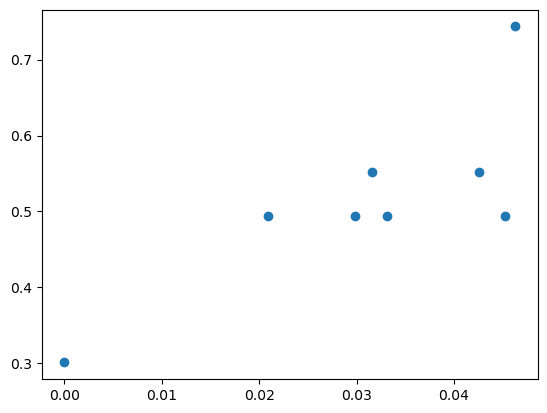

In [890]:
# load in position reference information
with open(path+ 'awake_seq_neuron_position_ref_dfs.pickle', 'rb') as f:
    awake_seq_neuron_position_ref_dfs = pickle.load(f)

# load in all spike data for sleep:
sleep_spike_data = pd.read_csv(r'Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\striatum\New_Post_sleep\178_1_7_run_1207023_1350\analysis_output\chunk1_8300to10000\\' + 'filtered_replay_clusters_df.csv')


# first plot raw rasters.

FileNotFoundError: [Errno 2] No such file or directory: 'Z:\\projects\\sequence_squad\\organised_data\\ppseq_data\\output_data\\striatum\\New_Post_sleep\\178_1_7_run_1207023_1350\\analysis_output\\chunk1_8300to10000\\temporal_structure_analysis\\\\awake_seq_neuron_position_ref_dfs.pickle'

In [884]:
fivex_events

,Unnamed: 0,cluster_seq_type,num_spikes,num_neurons,first_spike_time,event_length,last_spike_time,cluster_spike_times,cluster_neurons,spike_plotting_order,coactive_cluster_group,catagory,warp_factor,task_involved
24,24,1,11,73.0536,72.8879,0.1657,73.0536,"[72.8879, 72.9207, 72.987, 72.9793, 72.9453, 7...","[57.0, 57.0, 58.0, 61.0, 65.0, 65.0, 65.0, 65....",[ 70. 70. 105. 74. 72. 72. 72. 72. 72. ...,23.0,forward,5.335202,1
183,183,1,9,564.9762,564.9000,0.0762,564.9762,"[564.9547, 564.9762, 564.9, 564.912, 564.9234,...","[69.0, 69.0, 77.0, 77.0, 77.0, 79.0, 79.0, 113...",[42. 42. 73. 73. 73. 85. 85. 75. 75.],165.0,forward,4.670129,1
190,190,1,9,605.0233,604.9743,0.0490,605.0233,"[604.9799, 605.0018, 604.9743, 605.0093, 605.0...","[57.0, 57.0, 65.0, 68.0, 75.0, 75.0, 87.0, 112...",[70. 70. 72. 78. 76. 76. 80. 55. 75.],171.0,forward,5.025250,1
243,243,1,5,779.9973,779.9375,0.0598,779.9973,"[779.9727, 779.9523, 779.9586, 779.9973, 779.9...","[68.0, 77.0, 77.0, 79.0, 113.0]",[78. 73. 73. 85. 75.],212.0,forward,5.112817,1
325,325,1,6,1127.9190,1127.8626,0.0564,1127.9190,"[1127.8626, 1127.8857, 1127.919, 1127.9007, 11...","[65.0, 65.0, 65.0, 68.0, 113.0, 118.0]",[72. 72. 72. 78. 75. 57.],290.0,forward,4.565287,1
426,426,1,8,1471.6801,1471.6467,0.0334,1471.6801,"[1471.6592, 1471.676, 1471.672, 1471.6801, 147...","[65.0, 65.0, 67.0, 72.0, 113.0, 113.0, 113.0, ...",[72. 72. 79. 27. 75. 75. 75. 75.],378.0,forward,4.518133,1
627,627,3,5,1598.4081,1598.3357,0.0724,1598.4081,"[1598.3796, 1598.3357, 1598.3487, 1598.3539, 1...","[10.0, 58.0, 58.0, 58.0, 95.0]",[112. 105. 105. 105. 111.],546.0,forward,4.627615,1
1315,1315,5,11,248.7422,248.6456,0.0966,248.7422,"[248.7005, 248.7051, 248.7422, 248.7207, 248.7...","[7.0, 7.0, 31.0, 40.0, 112.0, 114.0, 114.0, 11...",[32. 32. 37. 44. 55. 59. 59. 59. 45. 40. 40.],609.0,forward,5.071182,1
1325,1325,5,7,538.5728,538.5349,0.0379,538.5728,"[538.5728, 538.5707, 538.5349, 538.5559, 538.5...","[40.0, 69.0, 114.0, 114.0, 114.0, 118.0, 120.0]",[44. 42. 59. 59. 59. 57. 9.],1024.0,forward,4.769925,1
1355,1355,5,7,1323.5142,1323.4600,0.0542,1323.5142,"[1323.4812, 1323.5142, 1323.4667, 1323.4694, 1...","[40.0, 40.0, 61.0, 113.0, 114.0, 121.0, 122.0]",[44. 44. 74. 75. 59. 84. 45.],915.0,forward,4.819004,1


In [850]:
ast.literal_eval(fivex_events.cluster_spike_times.values[0])

[72.8879,
 72.9207,
 72.987,
 72.9793,
 72.9453,
 72.9935,
 73.0028,
 73.0113,
 73.0332,
 73.0412,
 73.0536]

# plot awake seq example

In [11]:
def split_list(nums):
    sublists = []
    current_sublist = [nums[0]]
    current_element = nums[0]
    for i in range(1,len(nums)):
        if nums[i] == current_element:
            current_sublist.append(nums[i])
        else:
            sublists.append(current_sublist)
            current_sublist = [nums[i]]
            current_element = nums[i]
    sublists.append(current_sublist)
    return sublists

In [12]:
mouse_session_recording = '262_1_4'
region = 'striatum'

## PATHS
PP_PATH = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\"
DAT_PATH = r"Z:\projects\sequence_squad\organised_data\animals\\"



## set ppseq file
for file_ in os.listdir(PP_PATH):
    if mouse_session_recording in file_:
        file = file_
        
save_path = PP_PATH + file + '\\analysis_output\\'
save_path = save_path + 'latent_composition_analysis\\'
        
## set dat_path:
for file_ in os.listdir(DAT_PATH):
    if mouse_session_recording.split('_')[0] in file_:
        if mouse_session_recording.split('_')[1] == file_[-1]:
            dat_path = os.path.join(DAT_PATH,file_)
for recording in os.listdir(os.path.join(DAT_PATH,dat_path)):
    if recording.split('_')[0][-1] == mouse_session_recording.split('_')[-1]:
        dat_path = os.path.join(dat_path,recording)
        
# set tracking path
for file_ in os.listdir(dat_path + r"\video\tracking\\"):
    if 'task' in file_:
        if not 'clock' in file_:
            tracking_path = os.path.join(dat_path + r"\video\tracking\\",file_) + '\\'
# set video paths
for file_ in os.listdir(dat_path + r"\video\videos\\"):
    if 'task' in file_:
        if not 'clock' in file_:
            cam_path = os.path.join(dat_path + r"\video\videos\\",file_) + '\\' 
            for vid_file in os.listdir(cam_path):
                if 'back' in vid_file and '.avi' in vid_file:
                    back_cam_avi_path = os.path.join(cam_path,vid_file)
                if 'side' in vid_file and '.avi' in vid_file:
                    side_cam_avi_path = os.path.join(cam_path,vid_file)

In [13]:

print('\n')
print("LOADING processed_spike_data")
### load in releavent things:

import pickle
with open(PP_PATH + file + "\\analysis_output\\" + "spikes_seq_type_adjusted.pickle", "rb") as input_file:
    AWAKE_unmasked_spikes_df = pickle.load(input_file)

with open(os.path.join(os.path.join(PP_PATH,file) + r"\analysis_output\reordered_recolored\neuron_order"), "rb") as input_file:
    AWAKE_neuron_order = pickle.load(input_file)
    
with open(os.path.join(os.path.join(PP_PATH,file) + r"\analysis_output\reordered_recolored\colors"), "rb") as input_file:
    AWAKE_colors = pickle.load(input_file)
    
with open(os.path.join(os.path.join(PP_PATH,file) + r"\analysis_output\reordered_recolored\neuron_index"), "rb") as input_file:
    AWAKE_neuron_index = pickle.load(input_file)
    
AWAKE_ordered_preferred_type = np.load(PP_PATH + file + "\\analysis_output\\" + 'ordered_preferred_type.npy')

## load in the timespan used for pppseq:
input_params_path = os.path.join(PP_PATH + file,'trainingData\\') + ('params_' + mouse_session_recording +'.json')
# Opening JSON file
f = open(input_params_path)
# returns JSON object as  a dictionary
input_config = json.load(f)
AWAKE_behav_time_interval_start = input_config['time_span'][0]
print(f"      A corresponding time span has been found. Time span set to {AWAKE_behav_time_interval_start}")


## LOAD behaviour data
print('\n')
print("LOADING BEHAV DATA")
AWAKE_behav_sync = pd.read_csv(dat_path + r'\behav_sync\2_task\Behav_Ephys_Camera_Sync.csv')
transitions = pd.read_csv(dat_path + r'\behav_sync\2_task\Transition_data_sync.csv')

behav_mask = (AWAKE_behav_sync.PokeIN_EphysTime>AWAKE_behav_time_interval_start[0])*(AWAKE_behav_sync.PokeIN_EphysTime<(AWAKE_behav_time_interval_start[1]))
poke_in_times = (AWAKE_behav_sync[behav_mask].PokeIN_EphysTime) - AWAKE_behav_time_interval_start[0]
ports = AWAKE_behav_sync[behav_mask].Port
print('done')




LOADING processed_spike_data
      A corresponding time span has been found. Time span set to [5900, 6500]


LOADING BEHAV DATA
done


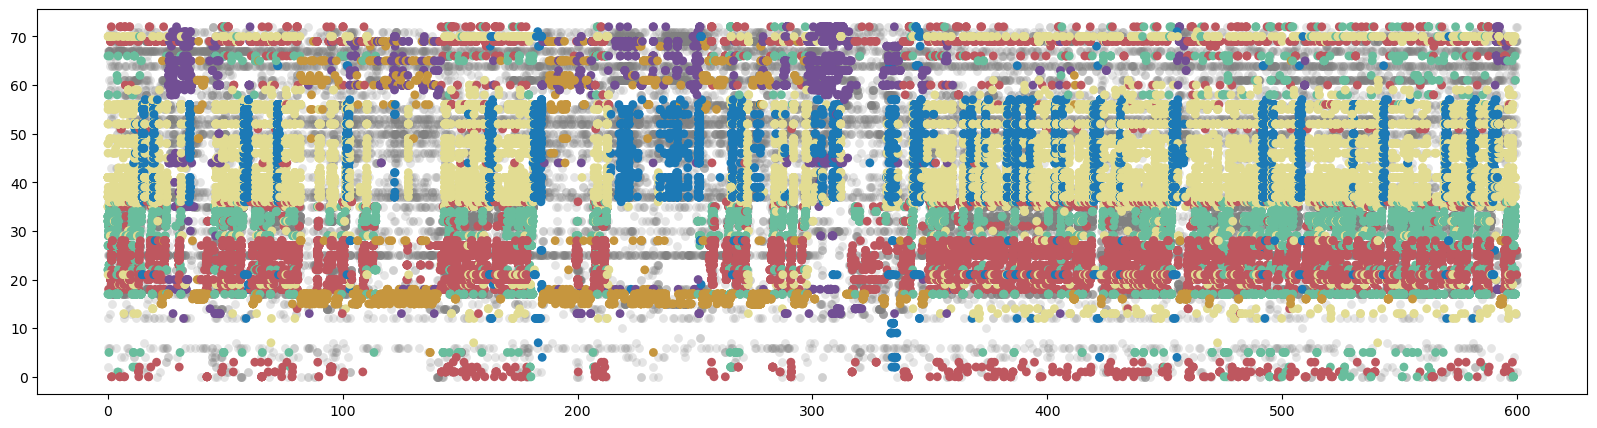

In [14]:
### Plot sequences - basic
timeframe = [0,600]
mask = (AWAKE_unmasked_spikes_df.timestamp>timeframe[0])*(AWAKE_unmasked_spikes_df.timestamp<timeframe[-1])

fig, ax = plt.subplots(1, 1,figsize=(20, 5))

# plot background in grey 
background_keep_mask = AWAKE_unmasked_spikes_df[mask].sequence_type_adjusted <= 0
ax.scatter(AWAKE_unmasked_spikes_df[mask][background_keep_mask].timestamp, AWAKE_neuron_order[mask][background_keep_mask],marker = 'o', s=40, linewidth=0,color = 'grey' ,alpha=0.2)

# plot spikes without background
background_remove_mask = AWAKE_unmasked_spikes_df[mask].sequence_type_adjusted >= 0
c_ = np.array(AWAKE_colors)[AWAKE_unmasked_spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
# ## faster:
ax.scatter(AWAKE_unmasked_spikes_df[mask][background_remove_mask].timestamp, AWAKE_neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)

### add chunk lines:
## work out ordering chunk sizes
split_lists = split_list(AWAKE_ordered_preferred_type[AWAKE_neuron_index])
lens = []
for list_ in split_lists:
    lens += [len(list_)]
chunks = [sum(lens[0:int(np.unique(AWAKE_ordered_preferred_type)[-1]+1)])] + lens[int(np.unique(AWAKE_ordered_preferred_type)[-1]+1)::] 



In [4]:
def find_corresponding(nums):
    return [df_dict[num] for num in nums]


In [ ]:
PP_PATH = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\"

DAT_PATH = r"Z:\projects\sequence_squad\organised_data\animals\\"

# pp_file = '178_1_7_run_1207023_1350'
# pp_file = '255_1_1_run_2006023_0409'
pp_file = '255_1_2_run_2106023_1837'
# pp_file = '262_1_6_run_1906023_1532'
pp_file = '262_1_4_run_2106023_2357'





mir = '_'.join(pp_file.split('_')[0:3])

mouse_session_recording = pp_file.split('_')[0] + '_' + pp_file.split('_')[1] + '_' + pp_file.split('_')[2] 
region = PP_PATH.split('\\')[6]

save_path = PP_PATH + pp_file + '\\analysis_output\\'
if not os.path.isdir(save_path):
    os.makedirs(save_path)

## set dat_path:
for file_ in os.listdir(DAT_PATH):
    if mouse_session_recording.split('_')[0] in file_:
        if mouse_session_recording.split('_')[1] == file_[-1]:
            dat_path = os.path.join(DAT_PATH,file_)
for recording in os.listdir(os.path.join(DAT_PATH,dat_path)):
    if recording.split('_')[0][9::] == mouse_session_recording.split('_')[-1]:
        dat_path = os.path.join(dat_path,recording)

        
        
        
# set tracking path
for file_ in os.listdir(dat_path + r"\video\tracking\\"):
    if 'task' in file_:
        if not 'clock' in file_:
            tracking_path = os.path.join(dat_path + r"\video\tracking\\",file_) + '\\'
# set video paths
for file_ in os.listdir(dat_path + r"\video\videos\\"):
    if 'task' in file_:
        if not 'clock' in file_:
            cam_path = os.path.join(dat_path + r"\video\videos\\",file_) + '\\' 
            for vid_file in os.listdir(cam_path):
                if 'back' in vid_file and '.avi' in vid_file:
                    back_cam_avi_path = os.path.join(cam_path,vid_file)
                if 'side' in vid_file and '.avi' in vid_file:
                    side_cam_avi_path = os.path.join(cam_path,vid_file)

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------    
## LOAD 
print("LOADING PPSEQ DATA")
print('\n')
#The assignment history frame (assigment_hist_frame.csv): Spikes by iterations, how each spike is assigned to a sequence ID (in latent_event_hist) or to background (-1)
assignment_history_df = pd.read_csv(PP_PATH + pp_file + r"\assigment_hist_frame.csv")

# latent_event_hist.csv: history of latent events. All latent events across all iterations have a row
latent_event_history_df = pd.read_csv(PP_PATH + pp_file + r"\latent_event_hist.csv")

# seq_type_log_proportions: log p of each type of sequence at each iteration
seq_type_log_proportions_df = pd.read_csv(PP_PATH + pp_file + r"\seq_type_log_proportions.csv")

# neuron_responses.csv: iterations x neurons by 3(number of sequences). Each neuron has three parameters per sequence to describe how it is influenced by each sequence type. 
# Each iteration these are resampled, therefore there are number of neurons by iterations by 3 by number of sequences of these numbers.
neuron_response_df = pd.read_csv(PP_PATH + pp_file + r"\neuron_response.csv")


masking = False
for dat_files in os.listdir(PP_PATH + pp_file):
    if 'unmasked_spikes' in dat_files:
        masking = True
        print('masking was used')

if masking == True:
    #log_p_hist.csv: the history of the log_p of the model
    log_p_hist_df = pd.read_csv(PP_PATH + pp_file + r"\test_log_p_hist.csv")

    unmasked_spikes_df = pd.read_csv(PP_PATH + pp_file + r"\unmasked_spikes.csv")
else:
    log_p_hist_df = pd.read_csv(PP_PATH + pp_file + r"\log_p_hist.csv")

    spikes_file = os.path.join(PP_PATH + pp_file,'trainingData\\') + mouse_session_recording + '.txt'
    neuron_ids, spike_times= [], []
    with open(spikes_file) as f:
        for (i, line) in enumerate(f.readlines()):
            [neuron_id, spike_time] = line.split(' ', 1)
            spike_time = eval(spike_time.split('\n')[0])
            neuron_id = eval(neuron_id.split('\t')[0])
            spike_times.append(spike_time)
            neuron_ids.append(neuron_id)
    unmasked_spikes_df = pd.DataFrame({'neuron':neuron_ids,'timestamp':spike_times}) 

bkgd_log_proportions_array = pd.read_csv(PP_PATH + pp_file + r"\bkgd_log_proportions_array.csv")


# Opening JSON file
f = open(PP_PATH + pp_file + r'\config_file.json')
# returns JSON object as a dictionary
config = eval(json.load(f))
print(f'      done')

## LOAD behaviour data
print('\n')
print("LOADING BEHAV DATA")

## load in the timespan used for pppseq:
input_params_path = os.path.join(PP_PATH + pp_file,'trainingData\\') + ('params_' + mouse_session_recording +'.json')
# Opening JSON file
f = open(input_params_path)
# returns JSON object as 
# a dictionary
input_config = json.load(f)
behav_time_interval_start = input_config['time_span']
print(f"      A corresponding time span has been found. Time span set to {behav_time_interval_start}")

### load in data:
for sub_file in os.listdir(dat_path + '\\behav_sync\\'):
    if 'task' in sub_file:
        behav_sync_path = dat_path + '\\behav_sync\\' + sub_file +'\\'
behav_sync = pd.read_csv(behav_sync_path + 'Behav_Ephys_Camera_Sync.csv')
transitions = pd.read_csv(behav_sync_path + 'Transition_data_sync.csv')

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------    

#find max value

# find 95% of growth value and when it crossed this
max_ = max(log_p_hist_df.x1)
min_ = min(log_p_hist_df.x1)
growth = max_ - min_
_prcntile =  max_ - (0.02 * growth)

## model log likley hood curve
plt.plot(log_p_hist_df.x1)
plt.axhline(y=_prcntile, color='r', linestyle='--')

In [ ]:
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------    

## macth seq id to seq type across itterations

# Initialize an empty df to store the result
seq_types_df = pd.DataFrame()

# Iterate through the range
# for iteration_ in tqdm(range(400, 500)):
for iteration_ in tqdm(range(200, 300)):

    # Extract the relevant column from the assignment history dataframe
    assignment_history_df_split = assignment_history_df[str(list(assignment_history_df)[iteration_])]

    # Get the index of the -1 split markers in the latent event history dataframe
    end_markers = latent_event_history_df.loc[latent_event_history_df['seq_type'] == -1.0].index
    # Extract the relevant portion of the latent event history dataframe
    latent_event_history_df_split =  latent_event_history_df[end_markers[iteration_-1]:end_markers[iteration_]]

    # Create a dictionary from the dataframe for faster lookups
    df_dict = latent_event_history_df_split.set_index('assignment_id')['seq_type'].to_dict()

    # Match the sequence ID to the sequence type
    seq_type = find_corresponding(assignment_history_df_split)

    # Append the result to the df
    seq_types_df[str(iteration_+1)] = seq_type


proportion = []
seq_type = []
for index in tqdm(range(len(seq_types_df))):
    row = seq_types_df.loc[index]
    seq_type += [statistics.mode(row)] 
    proportion += [np.count_nonzero(row == statistics.mode(row)) / len(row)]

# add seq type to dataframe
unmasked_spikes_df['sequence_type'] = seq_type
# add seq type to dataframe
unmasked_spikes_df['seq_confidence'] = proportion

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------    

## filter for background confidence :

thresh = max(proportion) *.75
plt.plot(np.sort(proportion)[::-1])
plt.axhline(y = thresh, color = 'r', linestyle = '-')

unmasked_spikes_df['sequence_type_adjusted'] = seq_type
unmasked_spikes_df.sequence_type_adjusted[np.where(unmasked_spikes_df.seq_confidence < thresh)[0]] = -1



 # -------------------------------------------------------------------------------------------------------------------------------------------------------------------    

awake_PP_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\"

for file_ in os.listdir(awake_PP_path):
    if mouse_session_recording in file_:
        awake_file = file_


ordered_preferred_type = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'ordered_preferred_type')

neuron_index = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'neuron_index')

colors = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'colors')

spikes_df = unmasked_spikes_df

colors += ['pink','lightblue', 'k'] 

In [ ]:
#####################################################################################################################################################################################################

%matplotlib inline
# %matplotlib notebook

# caluclate interval timings and end points
interval_lengths =[]
for interval in behav_time_interval_start:
    interval_lengths+= [np.diff(interval)[0]]
total_time = sum(interval_lengths)
interval_end_points = np.cumsum(interval_lengths)

### Plot sequences - basic

# 10
timeframe = [1943,1960]
# timeframe = [400,420]
timeframe = [1198,1202]

mask = (spikes_df.timestamp>timeframe[0])*(spikes_df.timestamp<timeframe[-1])

## neuron order:

#define neuron order
neuron_permute_loc = np.zeros(len(neuron_index))
for i in range(len(neuron_index)):
    neuron_permute_loc[i] = int(list(neuron_index).index(i))
neuron_order = neuron_permute_loc[(spikes_df.neuron-1).astype(int)]


## plotting:

fig, [ax,ax2] = plt.subplots(1, 2,figsize=(20, 5))



# plot background in grey 
background_keep_mask = []
for item in spikes_df[mask].sequence_type_adjusted:
    if item < 0 or item >= 7.0:
        background_keep_mask.append(True)
    else:
        background_keep_mask.append(False)
background_keep_mask = np.array(background_keep_mask)
ax2.scatter(spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=20, linewidth=0,color = 'lightgrey' ,alpha=0.5)

# plot spikes without background
background_remove_mask = spikes_df[mask].sequence_type_adjusted >= 0
background_remove_mask = (spikes_df[mask].sequence_type_adjusted >= 0)*(spikes_df[mask].sequence_type_adjusted != 7.0)*(spikes_df[mask].sequence_type_adjusted != 8.0)
c_ = np.array(colors)[spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
# ## faster:
ax2.scatter(spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=20, linewidth=0,color = c_ ,alpha=1)
ax2.set_title('held sequences in colour and extra sequences + background in grey')


##########

## plot awake:

### Plot sequences - basic
timeframe2 = [0,600]
mask = (AWAKE_unmasked_spikes_df.timestamp>timeframe2[0])*(AWAKE_unmasked_spikes_df.timestamp<timeframe2[-1])


# plot background in grey 
background_keep_mask = AWAKE_unmasked_spikes_df[mask].sequence_type_adjusted <= 0
ax.scatter(AWAKE_unmasked_spikes_df[mask][background_keep_mask].timestamp, AWAKE_neuron_order[mask][background_keep_mask],marker = 'o', s=20, linewidth=0,color = 'grey' ,alpha=0.5)

# plot spikes without background
background_remove_mask = AWAKE_unmasked_spikes_df[mask].sequence_type_adjusted >= 0
c_ = np.array(AWAKE_colors)[AWAKE_unmasked_spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
# ## faster:
ax.scatter(AWAKE_unmasked_spikes_df[mask][background_remove_mask].timestamp, AWAKE_neuron_order[mask][background_remove_mask],marker = 'o', s=20, linewidth=0,color = c_ ,alpha=1)

### add chunk lines:
## work out ordering chunk sizes
split_lists = split_list(AWAKE_ordered_preferred_type[AWAKE_neuron_index])
lens = []
for list_ in split_lists:
    lens += [len(list_)]
chunks = [sum(lens[0:int(np.unique(AWAKE_ordered_preferred_type)[-1]+1)])] + lens[int(np.unique(AWAKE_ordered_preferred_type)[-1]+1)::] 



# SaveFig('epoch_example_' + str(timeframe[0]) + '_' + str(timeframe[-1]) + '.pdf',r'Z:\projects\Emmett\Documents\writeup\fig7_replay\examples\\')


In [ ]:
timeframe = [0,3000]


mask = (spikes_df.timestamp>timeframe[0])*(spikes_df.timestamp<timeframe[-1])

## neuron order:

#define neuron order
neuron_permute_loc = np.zeros(len(neuron_index))
for i in range(len(neuron_index)):
    neuron_permute_loc[i] = int(list(neuron_index).index(i))
neuron_order = neuron_permute_loc[(spikes_df.neuron-1).astype(int)]


## plotting:

fig, ax = plt.subplots(1, 1,figsize=(20, 5))



# plot background in grey 
background_keep_mask = []
for item in spikes_df[mask].sequence_type_adjusted:
    if item < 0 or item >= 7.0:
        background_keep_mask.append(True)
    else:
        background_keep_mask.append(False)
background_keep_mask = np.array(background_keep_mask)
# ax.scatter(spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=20, linewidth=0,color = 'lightgrey' ,alpha=0.2)

# plot spikes without background
background_remove_mask = spikes_df[mask].sequence_type_adjusted >= 0
background_remove_mask = (spikes_df[mask].sequence_type_adjusted >= 0)*(spikes_df[mask].sequence_type_adjusted != 7.0)*(spikes_df[mask].sequence_type_adjusted != 8.0)
c_ = np.array(colors)[spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
# ## faster:
ax.scatter(spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=20, linewidth=0,color = c_ ,alpha=1)
ax.set_title('held sequences in colour and extra sequences + background in grey')

In [ ]:
neuron_index
behvavioural_tiem_interval

spikes_df

In [ ]:
spikes_df[mask]

In [ ]:
## example times:
#yellow 1406 1410
#blue 320 335
#red 1685 1695
#green 740 755
#purple 2225 2235


#full example: 3375,3385

# awake example = 240,250